# Marine Debris Classification

This project shows the steps towards constructing a machine learning pipeline for detecting marine debris. We will use satellite images obtained by ESA's Sentinel-2 and [MARIDA](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0262247) dataset to build our classifier.

MARIDA dataset consists in georeferenced pixels on S2 satellite imagery. Here we just consider the ground-truth data (Class and Confidence). The data are extracted directly through [eo-learn](https://eo-learn.readthedocs.io/en/latest/index.html) library: a collection of python packages that allows access to Copernicus satellite observations.

## Before you start

### Recommended packages installation

After package installation you should restart the kernel.

In [1]:
# !conda install python=3.7.12 -y
# !conda install matplotlib=3.5.2 -y
# !conda install numpy=1.21.6 -y
# !conda install pandas=1.3.5 -y
# !conda install seaborn=0.11.2 -y
# !conda install jupyter=1.0.0 -y
# !pip install scikit-image=0.19.2 -y 
# !conda install scikit-learn=1.0.2 -y
# !pip install aenum=3.1.11 -y
# !conda install -c conda-forge tqdm=4.64.0 -y
# !conda install gdal=3.4.0 -y
# !conda install rasterio=1.2.10 -y
# !conda install shapely=1.8.0 -y
# !conda install fiona=1.8.20 -y
# !pip install sentinelhub==3.5.2
# !pip install eo-learn==1.0.2
# !pip install eo-learn-core==1.0.2
# !pip install eo-learn-coregistration==1.0.2
# !pip install eo-learn-features==1.0.2
# !pip install eo-learn-geometry==1.0.2
# !pip install eo-learn-io==1.0.2
# !pip install eo-learn-mask==1.0.2
# !pip install eo-learn-ml-tools==1.0.2
# !pip install eo-learn-visualization==1.0.2

### Requirements

In order to run the example you’ll need a Sentinel Hub account. If you do not have one yet, you can create a free trial account at [Sentinel Hub webpage](https://services.sentinel-hub.com/oauth/subscription?param_domain_id=1&param_redirect_uri=https://apps.sentinel-hub.com/dashboard/oauthCallback.html&param_state=%2F&param_scope=&param_client_id=30cf1d69-af7e-4f3a-997d-0643d660a478&domainId=1). If you are a researcher you can even apply for a free non-commercial account at [ESA OSEO page](https://earth.esa.int/aos/OSEO).


Once you have the account set up, please configure the ```sentinelhub``` package’s configuration file following the [configuration instructions](https://sentinelhub-py.readthedocs.io/en/latest/configure.html). For Processing API request you need to obtain and set your ```oauth``` client id and secret.

In [2]:
# from sentinelhub import SHConfig

# config = SHConfig()

# config.instance_id = ''
# config.sh_client_id = ''
# config.sh_client_secret = ''

# config.save()

### Overview

#### Part 1:

1.   Use eo-learn package in order to fill the EOPatches with band data and indices computed from band combination (FAI, FDI, NDVI, NDWI, NDMI)
2.   Extract texture features (GLCM)

#### Part 2:

3.   Prepare the training data

    * Create a `Dataframe` with all information: bands, indices and texture features
    * Preprocessing and preliminary analysis

4.   Model selection

    * Perform a `GridSearchCV` and choose the best estimator with optimal parameters

5.   Training and evaluation

    * Try feature selection (PCA, RFE)
    * Consider a Water Superclass model

6.   Prediction and visualization of the results

### Imports

In [3]:
# General imports
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

import datetime
import os
from glob import glob
from skimage.feature import graycomatrix, graycoprops
from skimage.color import rgb2gray
import rasterio
from aenum import MultiValueEnum
from matplotlib.colors import ListedColormap, BoundaryNorm
from tqdm import tqdm

# Sentinel Hub imports
from eolearn.core import (
    EOTask,
    EOPatch,
    EOWorkflow,
    linearly_connect_tasks,
    FeatureType,
    OverwritePermission,
    LoadTask,
    SaveTask,
    EOExecutor
)

from sentinelhub import BBox
from sentinelhub import DataCollection
from eolearn.io import SentinelHubInputTask, ImportFromTiffTask
from eolearn.features import NormalizedDifferenceIndexTask

# Classification imports
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, \
    HistGradientBoostingClassifier
import joblib # Save and Load classifier

from sklearn.decomposition import PCA # PCA Feature Extraction (unsupervised)
from sklearn.feature_selection import RFE # RFE Feature Extraction (supervised)

from sklearn.metrics import roc_auc_score

# Set random_state so the experiment can be repeated obtaining 
# the same results
random_state = 42
np.random.seed(random_state)

In [4]:
# Folder containing MARIDA patches
# and where the dataframe will be stored
DATA_FOLDER = os.path.join(".", "data")

# Folder where MARIDA images are stored
PATCHES_FOLDER = os.path.join(DATA_FOLDER, 'patches')

# Folder where EOPatches will be stored
EOPATCH_FOLDER = os.path.join(".", "eopatches")

# Folder where models will be stored
RESULTS_FOLDER = os.path.join(".", "results")

# Filename of the dataframe
CSV_FILE = 'df.csv'

for folder in (EOPATCH_FOLDER, RESULTS_FOLDER):
    os.makedirs(folder, exist_ok=True)

# Part 1

## 1.   Use eo-learn package in order to fill the EOPatches with band data and indices computed from band combination (FAI, FDI, NDVI, NDWI, NDMI)

Create EOPatches and fill them with Sentinel-2 data using Sentinel Hub services:

* Sentinel-2 spectral [bands](https://en.wikipedia.org/wiki/Sentinel-2#Spectral_bands):

| Band | Wavelenght | Description       |
|------|------------|-------------------|
| B1   | 442.7nm    | Coastal Aerosol   |
| B2   | 492.4nm    | Blue              |
| B3   | 559.8nm    | Green             |
| B4   | 664.6nm    | Red               |
| B5   | 704.1nm    | VNIR Red Edge 1   |
| B6   | 740.5nm    | VNIR Red Edge 2   |
| B7   | 782.8nm    | VNIR Red Edge 3   |
| B8   | 832.8nm    | NIR               |
| B8A  | 864.7nm    | Narrow NIR        |
| B9   | 945.1nm    | SWIR Water Vapour |
| B10  | 1373.5nm   | SWIR Cirrus       |
| B11  | 1613.7nm   | SWIR1             |
| B12  | 2202.4nm   | SWIR2             |

* Bands combination:

  * [**FAI**](https://www.researchgate.net/publication/333838040_Performance_Evaluation_of_Newly_Proposed_Seaweed_Enhancing_Index_SEI) (Floating Algae Index) is an index used for mapping
floating algae in many aquatic environments. Tipically, floating algae on the water surface have higher reflectance in the near-infrared (NIR) than other
wavelengths and thus can be easily distinguished from the surrounding clear waters.

  * [**FDI**](https://www.nature.com/articles/s41598-020-62298-z) (Floating Debris Index), based on FAI, is able to detect floating materials such as seaweed, sea foam, and macroplastics).

  * [**NDVI**](https://custom-scripts.sentinel-hub.com/sentinel-2/ndvi/) (Normalized Difference Vegetation Index) is a simple, but effective index for quantifying green vegetation.

  * [**NDWI**](https://custom-scripts.sentinel-hub.com/sentinel-2/ndwi/) (Normalized Difference Water Index) uses green and near infrared bands to highlight water bodies. As water bodies strongly absorb light in visible to infrared electromagnetic spectrum.

  * [**NDMI**](https://custom-scripts.sentinel-hub.com/sentinel-2/ndmi/) (Normalized Difference Moisture Index) is used to monitor changes in water content of leaves.

An EOPatch is created using EOTasks chained in a pipeline called EOWorkflow.
The full pipeline we build here has the following steps:


*   Download Sentinel-2 band data
*   Import class and confidence from MARIDA tiff images
*   Compute NDVI, NDWI, NDMI with predefined EOTasks
*   Compute FAI, FDI with custom EOTasks
*   Save the result into a selected folder

### Define custom EOTasks

In [5]:
# Bands
band_names = ["B01", "B02", "B03", "B04", "B05", "B06", "B07",
              "B08", "B8A", "B09", "B10", "B11", "B12"]

In [6]:
class FAI(EOTask):
    """
    FAI: B08 - (B04 + (B10 - B04) * 10*(wavelenght_B08 - wavelenght_B04)/
                                            (wavelenght_B10 - wavelenght_B04))
    """   
    
    @staticmethod
    def FAI(NIR,RED,SWIR):
        l_nir = 833.0
        l_red = 665.0
        l_swir = 1374.0
        factor = (l_nir - l_red) / (l_swir - l_red)
        
        return NIR - ( RED + ( SWIR - RED ) * factor)
    
    def __init__(self, feature_type, feature_name):
        self.type = feature_type
        self.name = feature_name
        
    def execute(self,
                eopatch,
                band_layer='BANDS', 
                band_names=band_names
                ):
        bands  = eopatch.data[band_layer]

        NIR = bands[:,:,:,band_names.index('B08')]
        RED  = bands[:,:,:,band_names.index('B04')]
        SWIR = bands[:,:,:,band_names.index('B10')]
        
        eopatch[self.type, self.name] = self.FAI(NIR,RED,SWIR)\
        .reshape([bands.shape[0], bands.shape[1], bands.shape[2], 1])        
        return eopatch

In [7]:
class FDI(EOTask):
    """
    FDI: B08 - (B06 + (B11 - B06) * 10*(wavelenght_B08 - wavelenght_B04)/
                                            (wavelenght_B11 - wavelenght_B04))
    """   
    
    @staticmethod
    def FDI(NIR,RE2,SWIR1):
        l_nir = 833.0
        l_red = 665.0
        l_swir1 = 1614.0
        factor = 10 * (l_nir - l_red) / (l_swir1 - l_red)
        
        return NIR - ( RE2 + ( SWIR1 - RE2 ) * factor)
    
    def __init__(self, feature_type, feature_name):
        self.type = feature_type
        self.name = feature_name
        
    def execute(self,
                eopatch,
                band_layer='BANDS', 
                band_names=band_names
                ):
        bands  = eopatch.data[band_layer]

        NIR = bands[:,:,:,band_names.index('B08')]
        RE2  = bands[:,:,:,band_names.index('B06')]
        SWIR1 = bands[:,:,:,band_names.index('B11')]
        
        eopatch[self.type, self.name] = self.FDI(NIR,RE2,SWIR1)\
        .reshape([bands.shape[0], bands.shape[1], bands.shape[2], 1])        
        return eopatch

### Define the workflow tasks

In [8]:
# Request for Sentinel-2 bands
input_task = SentinelHubInputTask(
    bands_feature=(FeatureType.DATA, "BANDS"),
    resolution=10,
    time_difference=datetime.timedelta(minutes=120),
    data_collection=DataCollection.SENTINEL2_L1C,
    max_threads=5
)

# Get Class and Confidence info from MARIDA tiff images
cl_tif = ImportFromTiffTask(
    (FeatureType.LABEL, "CLASS"), '.', image_dtype=np.uint8
)

conf_tif = ImportFromTiffTask(
    (FeatureType.LABEL, "CONF"), '.', image_dtype=np.uint8
)

# CALCULATING NEW FEATURES
# NDVI: (B08 - B04)/(B08 + B04)
# NDWI: (B03 - B08)/(B03 + B08)
# NDMI: (B08 - B11)/(B08 + B11)
NDVI = NormalizedDifferenceIndexTask(
    (FeatureType.DATA, "BANDS"), 
    (FeatureType.DATA, "NDVI"), 
    [band_names.index("B08"), 
     band_names.index("B04")]
)

NDWI = NormalizedDifferenceIndexTask(
    (FeatureType.DATA, "BANDS"), 
    (FeatureType.DATA, "NDWI"), 
    [band_names.index("B03"), 
     band_names.index("B08")]
)

NDMI = NormalizedDifferenceIndexTask(
    (FeatureType.DATA, "BANDS"), 
    (FeatureType.DATA, "NDMI"), 
    [band_names.index("B08"), 
     band_names.index("B11")]

)

fai = FAI(FeatureType.DATA, "FAI")

fdi = FDI(FeatureType.DATA, "FDI")

# Saving to output
save = SaveTask(path=EOPATCH_FOLDER, 
                overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

### Marida classes and confidence

The classes of MARIDA:

|        Class Name        |                           Description                           |
|:------------------------:|:---------------------------------------------------------------:|
|       Marine Debris      | Floating plastics or other polymers, mixed anthropogenic debris |
|      Dense Sargassum     |               Dense floating Sargassum macroalgae               |
|     Sparse Sargassum     |               Sparse floating Sargassum macroalgae              |
| Natural Organic Material |                        Vegetation & Wood                        |
|           Ship           |                    Sailing & Anchored Vessels                   |
|          Clouds          |                   Clouds including thin Clouds                  |
|       Marine Water       |                           Clear Water                           |
|   Sediment-Laden Water   |         High-Sediment river discharges with brown colour        |
|           Foam           |   Foam recorded at river fronts or coastal wave breaking area   |
|       Turbid Water       |               Turbid waters close to coastal areas              |
|       Shallow Water      |  Coastal waters, including coral reefs and submerged vegetation |
|           Waves          |                              Waves                              |
|       Cloud Shadows      |                          Cloud Shadows                          |
|           Wakes          |               Wakes & Waves from a sailing vessel               |
|        Mixed Water       |                  Water near floating materials                  |

MARIDA dataset has been collected by gathering reports on marine pollution, observations by photographers and scientists from social media. Then, three iamge-interpretation experts annotated the satellite images and assigned to each pixel a level of confidence (High, Moderate, Low).

We have defined two enum for Class and Confidence for ease of use below.

In [9]:
class MDC(MultiValueEnum):
    """Enum class containing basic marine debris types"""

    NO_DATA = "No Data", 0, "#ffffff"
    MARINE_DEBRIS = "Marine Debris", 1, "#ff0000"
    DENSE_SARGASSUM = "Dense Sargassum", 2, "#008000"
    SPARSE_SARGASSUM = "Sparse Sargassum", 3, "#32cd32"
    NATURAL_ORGANIC_MATERIAL = "Natural Organic Material", 4, "#a52a2a"
    SHIP = "Ship", 5, "#ffa500"
    CLOUDS = "Clouds", 6, "#c0c0c0"
    MARINE_WATER = "Marine Water", 7, "#000080"
    SEDIMENT_LADEN_WATER = "Sediment-Laden Water", 8, "#ffd700"
    FOAM = "Foam", 9, "#800080"
    TURBID_WATER = "Turbid Water", 10, "#bdb76b"
    SHALLOW_WATER = "Shallow Water", 11, "#00ced1"
    WAVES = "Waves", 12, "#fff5ee"
    CLOUD_SHADOWS = "Cloud Shadows", 13, "#808080"
    WAKES = "Wakes", 14, "#ffff00"
    MIXED_WATER = "Mixed Water", 15, "#bc8f8f"
    
    @property
    def name(self):
        return self.values[0]
    
    @property
    def id(self):
        return self.values[1]

    @property
    def color(self):
        return self.values[2]


# Reference colormap things
mdc_cmap = ListedColormap([x.color for x in MDC], name="mdc_cmap")
mdc_norm = BoundaryNorm([x - 0.5 for x in range(len(MDC) + 1)], mdc_cmap.N)

In [10]:
class Conf_map(MultiValueEnum):
    """Enum class containing confidence mapping types"""
    
    NO_DATA = "No Data", 0, "#ffffff"
    HIGH = "High", 1, "#ff0000"
    MODERATE = "Moderate", 2, "#ffff00"
    LOW = "Low", 3, "#008000"
    
    @property
    def name(self):
        return self.values[0]

    @property
    def id(self):
        return self.values[1]

    @property
    def color(self):
        return self.values[2]


# Reference colormap things
conf_cmap = ListedColormap([x.color for x in Conf_map], name="conf_cmap")
conf_norm = BoundaryNorm([x - 0.5 for x in range(len(Conf_map) + 1)], 
                         conf_cmap.N)

### Define the workflow

Here we use the linear case of the EOWorkflow, available as ```LinearWorkflow```.

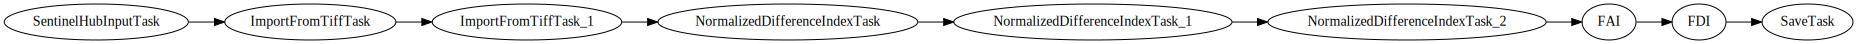

In [11]:
# Define the workflow
workflow_nodes = linearly_connect_tasks(
    input_task, cl_tif, conf_tif, NDVI, NDWI, NDMI, fai, fdi, save
)

workflow = EOWorkflow(workflow_nodes)

# Let's visualize it
workflow.dependency_graph()

In [12]:
# Define additional parameters of the workflow
input_node = workflow_nodes[0]
cl_node = workflow_nodes[1]
conf_node = workflow_nodes[2]
save_node = workflow_nodes[-1]
execution_args = []

# List of Class and Confidence images
patches = list(zip(glob(os.path.join(PATCHES_FOLDER, '*/*cl.tif')), 
                   glob(os.path.join(PATCHES_FOLDER, '*/*conf.tif'))))

for patch in patches:
    date_time = pd.to_datetime(os.path.basename(patch[0]).split('_')[1], 
                               format='%d-%m-%y')
    date_start = date_time - datetime.timedelta(days=1)
    date_end = date_time + datetime.timedelta(days=1)
    index = os.path.basename(patch[0]).split('_cl')[0]
    
    # Read the bound coordinates and the reference system
    with rasterio.open(patch[0], 'r') as cl_tiff:
        bounds = cl_tiff.bounds
        crs = cl_tiff.crs
    
    # Use previous info to request the EOPatch
    execution_args.append({
        input_node: {
            'bbox':BBox(bounds,crs=f'{crs}'),
            'time_interval': [date_start, date_end]
        },
        cl_node: {'filename': patch[0]},
        conf_node: {'filename': patch[1]},
        save_node : {"eopatch_folder": f"eopatch_{index}"}
    })

This procedure may take approximately ~55 minutes. You can skip it by downloading the EOPatches from [here](https://bit.ly/3PVTTdH). You must save eopatches folder in ./ as described in project structure.

In [13]:
# # Execute the workflow
# executor = EOExecutor(workflow, execution_args, save_logs=True)
# executor.run(workers=1)

# # This makes a log for each EOPatch plus a final summary
# executor.make_report()

# failed_ids = executor.get_failed_executions()
# if failed_ids:
#     raise RuntimeError(
#         f"Execution failed EOPatches with IDs:\n{failed_ids}\n"
#         f"For more info check report at {executor.get_report_path()}"
#     )

  0%|          | 0/1381 [00:00<?, ?it/s]

### Visualize the patches

Let's load a single EOPatch and look at the structure.

In [14]:
eopatch = EOPatch.load(os.path.join(EOPATCH_FOLDER, 
                                    'eopatch_S2_1-12-19_48MYU_0'))

We obtain the following structure:

In [15]:
eopatch

EOPatch(
  data={
    BANDS: numpy.ndarray(shape=(1, 256, 256, 13), dtype=float32)
    FAI: numpy.ndarray(shape=(1, 256, 256, 1), dtype=float32)
    FDI: numpy.ndarray(shape=(1, 256, 256, 1), dtype=float32)
    NDMI: numpy.ndarray(shape=(1, 256, 256, 1), dtype=float32)
    NDVI: numpy.ndarray(shape=(1, 256, 256, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(1, 256, 256, 1), dtype=float32)
  }
  label={
    CLASS: numpy.ndarray(shape=(1, 65536), dtype=uint8)
    CONF: numpy.ndarray(shape=(1, 65536), dtype=uint8)
  }
  meta_info={
    size_x: 256
    size_y: 256
    time_difference: 7200.0
    time_interval: ['2019-11-30T00:00:00', '2019-12-02T00:00:00']
  }
  bbox=BBox(((706740.0, 9338400.0), (709300.0, 9340960.0)), crs=CRS('32748'))
  timestamp=[datetime.datetime(2019, 12, 1, 3, 19, 39)]
)

### Visualize the RGB image, Class and Confidence map

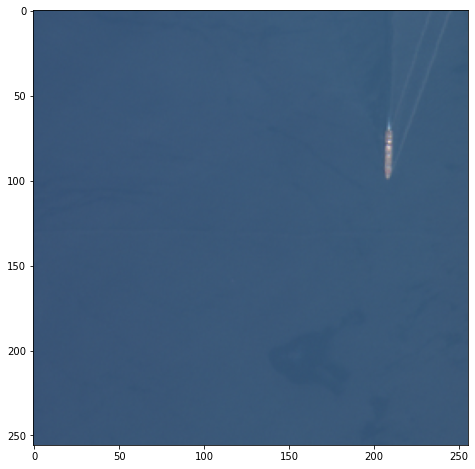

In [16]:
%matplotlib inline
 
# Draw the RGB image
fig, ax = plt.subplots(figsize=(8, 8))
# ax.set_xticks([])
# ax.set_yticks([])
ax.set_aspect("auto")

plt.imshow(np.clip(eopatch.data['BANDS'][0][..., [3,2,1]] * 3.5, 0, 1))
plt.show()

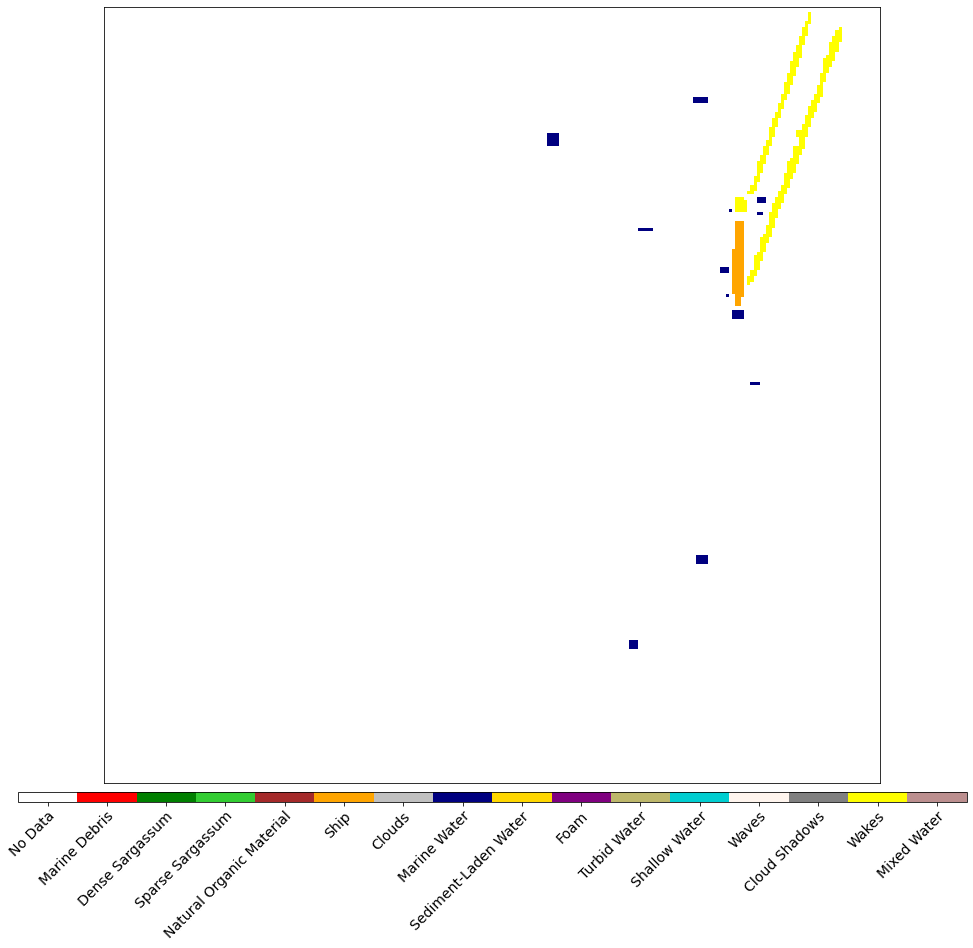

In [17]:
# Visualize the Class map
fig, ax = plt.subplots(figsize=(17,17))
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect("auto")

im = ax.imshow(np.reshape(eopatch.label['CLASS'], (256, 256)), 
               cmap=mdc_cmap, norm=mdc_norm)
cb = fig.colorbar(im, orientation="horizontal", pad=0.01, aspect=100)
cb.ax.tick_params(labelsize=14)
cb.set_ticks([entry.id for entry in MDC])
cb.ax.set_xticklabels([entry.name for entry in MDC], \
                      rotation=45, ha="right", rotation_mode="anchor")
plt.show()

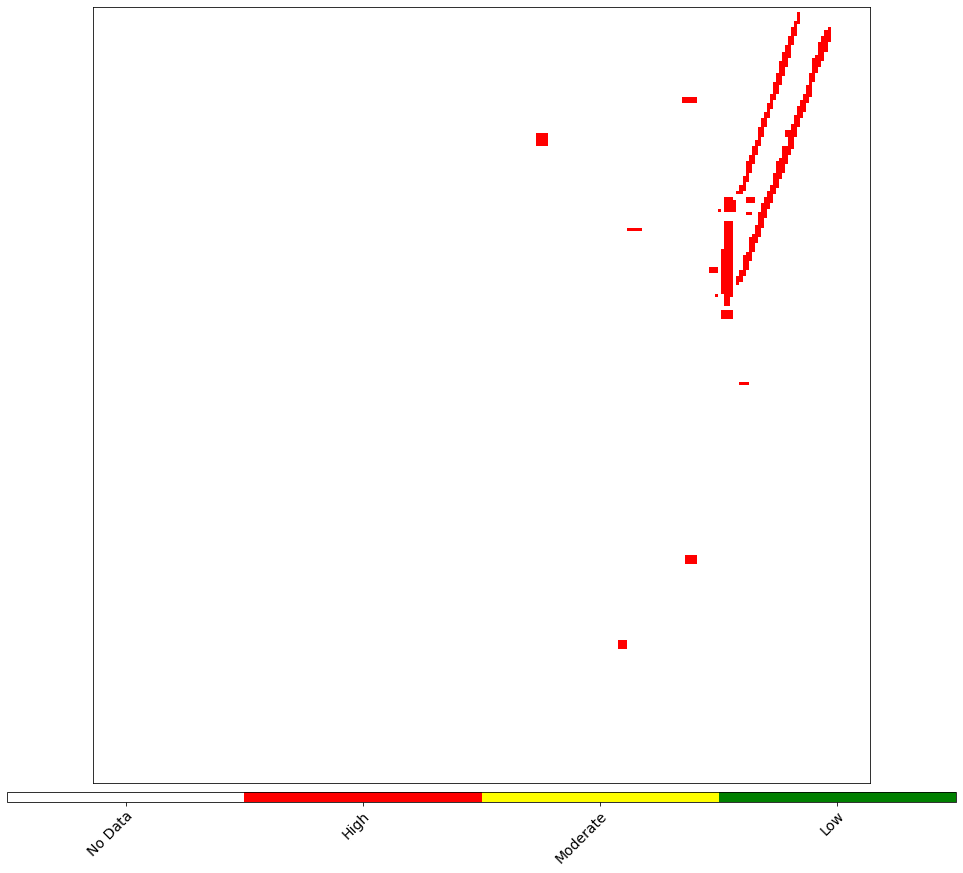

In [18]:
# Visualize the Confidence map
fig, ax = plt.subplots(figsize=(17,17))
ax.set_xticks([])
ax.set_yticks([])
ax.set_aspect("auto")

im = ax.imshow(np.reshape(eopatch.label['CONF'], (256, 256)), 
               cmap=conf_cmap, norm=conf_norm)
cb = fig.colorbar(im, orientation="horizontal", pad=0.01, aspect=100)
cb.ax.tick_params(labelsize=14)
cb.set_ticks([entry.id for entry in Conf_map])
cb.ax.set_xticklabels([entry.name for entry in Conf_map], \
                      rotation=45, ha="right", rotation_mode="anchor")
plt.show()

## 2.   Extract texture features (GLCM)

In [19]:
# GLCM properties
def glcm_feature(matrix_coocurrence):
    """Compute some metrics of the matrix"""
    contrast = graycoprops(matrix_coocurrence, 'contrast')
    dissimilarity = graycoprops(matrix_coocurrence, 'dissimilarity')
    homogeneity = graycoprops(matrix_coocurrence, 'homogeneity')
    energy = graycoprops(matrix_coocurrence, 'energy')
    correlation = graycoprops(matrix_coocurrence, 'correlation')
    asm = graycoprops(matrix_coocurrence, 'ASM')
    
    return contrast.item(), dissimilarity.item(), homogeneity.item(), \
        energy.item(), correlation.item(), asm.item()

In [20]:
def extract_texture_features(eopatch, window_size = 13, max_value = 16):
    """
    Calculate co-occurrence matrix and its metrics for an EOPatch
    window_size: size of the patch around a given pixel
    max_value: value used for quantization
    """
    
    features = eopatch.data["BANDS"]
    t, w1, h, f = features.shape
    if t==0:
        raise Exception('ERROR! Patch with empy data')
    
    data = np.full((1, w1 * h), 1)
    if 'CLASS' in eopatch.label:
        data = eopatch.label['CLASS']
    
    image = np.clip(features[0][..., [3,2,1]] * 3.5, 0, 1)
    gray = rgb2gray(image)

    bins = np.linspace(0.00, 1.00,max_value)
    num_levels = max_value+1
    temp_gray = np.pad(gray, (window_size-1)//2, mode='reflect')

    # Get list of coordinates of non zero pixel
    list_pixel = np.argwhere(
        np.reshape(data, (256, 256)) > 0) \
    + ((window_size-1)//2, (window_size-1)//2)

    # Get patch for each coordinates and compute GLCM on it
    res = []
    for p in list_pixel:
        temp_gray_window = temp_gray[p[0] - (window_size -1)//2: \
                                     p[0] + (window_size -1)//2 + 1, 
                                     p[1] - (window_size -1)//2: \
                                     p[1] + (window_size -1)//2 + 1]
        inds = np.digitize(temp_gray_window, bins)

        # Calculate on E, NE, N, NW as well as symmetric. 
        # Calculation on all directions and with 1 pixel offset-distance
        matrix_coocurrence = graycomatrix(
            inds, 
            [1], 
            [0, np.pi/4, np.pi/2, 3*np.pi/4], 
            levels=num_levels, 
            normed=True, 
            symmetric=True)

        # Aggregate all directions
        matrix_coocurrence = matrix_coocurrence.mean(3)[:,:,:,np.newaxis]
        con, dis, homo, ener, cor, asm = glcm_feature(matrix_coocurrence)
        res.append((con, dis, homo, ener, cor, asm))   
    
    res = np.asarray(res, dtype=np.float32)  
    return res

### Texture EOTask

In [21]:
class TextureTask(EOTask):
    """
    Task to extract texture properties
    """

    def __init__(self, feature_type, feature_name):
        self.type = feature_type
        self.name = feature_name

    def execute(self, eopatch):

        t, w, h, f = eopatch.data['BANDS'].shape
        texture_features = extract_texture_features(eopatch)
        
        data = np.full((1, w * h), 1)
        out = np.full((w * h, texture_features.shape[1]), 0, dtype=np.float32)
        if 'CLASS' in eopatch.label:
            data = eopatch.label['CLASS']
        data = np.squeeze(data)
        out[data>0] = texture_features
        out = out.reshape(t, w, h, texture_features.shape[1])
        eopatch[self.type, self.name] = out

        return eopatch

### Workflow definition

In [22]:
# Load existing EOPatch(es)
load = LoadTask(EOPATCH_FOLDER)

# Extract texture properties
texture = TextureTask(FeatureType.DATA, "TEXTURE")

# Save
save = SaveTask(EOPATCH_FOLDER, 
                overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

# Define the workflow
workflow_nodes = linearly_connect_tasks(load, texture, save)
workflow = EOWorkflow(workflow_nodes)

This procedure may take approximately ~10 minutes. If you downloaded the EOPatches from OneDrive you can skip this.

In [23]:
# execution_args = []

# # List of EOPatch names
# eopatch_paths = os.listdir(EOPATCH_FOLDER)

# for eop in eopatch_paths:
#     execution_args.append(
#     {
#         workflow_nodes[0]: {"eopatch_folder": f"{eop}"},
#         workflow_nodes[2]: {"eopatch_folder": f"{eop}"},
#     }
# )

# # Run the executor
# executor = EOExecutor(workflow, execution_args)
# executor.run(workers=1, multiprocess=False)
# executor.make_report()

# failed_ids = executor.get_failed_executions()
# if failed_ids:
#     raise RuntimeError(
#         f"Execution failed EOPatches with IDs:\n{failed_ids}\n"
#         f"For more info check report at {executor.get_report_path()}"
#     )

  0%|          | 0/1381 [00:00<?, ?it/s]

# Part 2

## 3.   Prepare the training data

Create a `Dataframe` with all information: bands, indices and texture features.

In [24]:
indices = ['FAI', 'FDI', 'NDMI', 'NDVI', 'NDWI']
info = ['Class', 'Confidence', 'Date', 'Tile', 'Image']
texture_cols = ['CON', 'DIS', 'HOMO', 'ENER', 'COR', 'ASM']
columns = band_names + indices + texture_cols + info

This procedure may take approximately ~10 minutes. You can skip this procedure by downloading the Dataframe from [here](https://bit.ly/3OWiApa). It must be saved in ./data folder.

In [25]:
# %%time

# df = pd.DataFrame(columns = columns)
# paths = glob(os.path.join(EOPATCH_FOLDER, '*'))

# for path in tqdm(paths):
#     eopatch = EOPatch.load(path, lazy_loading=True)
#     name = path.split('eopatch_')[1]
#     date = name.split('_')[1]
#     tile = name.split('_')[2]
#     image = name.split('_')[3]
    
#     features = eopatch.data["BANDS"]
    
#     FAI = eopatch.data['FAI']
#     FDI = eopatch.data['FDI']
#     NDMI = eopatch.data['NDMI']
#     NDVI = eopatch.data['NDVI']
#     NDWI = eopatch.data['NDWI']
#     TEXTURE = eopatch.data['TEXTURE']

#     CLASS = eopatch.label['CLASS']
#     CONF = eopatch.label['CONF']
    
#     t, w1, h, f = features.shape
#     if t == 0:
#         raise Exception('ERROR! Patch with empy data')

#     features = np.moveaxis(features, 0, 2).reshape(w1 * h, t * f)
#     t, w1, h, f = FAI.shape
#     FAI = np.moveaxis(FAI, 0, 2).reshape(w1 * h, t * f)
#     FDI = np.moveaxis(FDI, 0, 2).reshape(w1 * h, t * f)
#     NDMI = np.moveaxis(NDMI, 0, 2).reshape(w1 * h, t * f)
#     NDVI = np.moveaxis(NDVI, 0, 2).reshape(w1 * h, t * f)
#     NDWI = np.moveaxis(NDWI, 0, 2).reshape(w1 * h, t * f)
#     TEXTURE = np.moveaxis(TEXTURE, 0, 2).reshape(w1 * h, t * TEXTURE.shape[-1])
#     features = np.concatenate((features, FAI, FDI, NDMI, NDVI, NDWI, TEXTURE), 
#                               axis=1)

#     filter_class = np.squeeze(CLASS) > 0
#     filter_conf = np.squeeze(CONF) > 0

#     fcl_features = features[filter_class]
#     fcn_features = features[filter_conf]

#     if fcl_features.shape != fcn_features.shape:
#         raise Exception("Error filtering class is \
#             different from filtering conf")

#     column_date = np.full((fcl_features.shape[0], 1), date)
#     column_tile = np.full((fcl_features.shape[0], 1), tile)
#     column_image = np.full((fcl_features.shape[0], 1), image)
#     data = np.concatenate((fcl_features,
#                                CLASS.T[filter_class], 
#                                CONF.T[filter_conf], 
#                                column_date, 
#                                column_tile, 
#                                column_image), axis=1)

#     df = pd.concat([df, pd.DataFrame(data, columns=columns)])


# df.reset_index(drop=True, inplace=True)
# df[band_names+indices+texture_cols] = \
#     df[band_names+indices+texture_cols].astype(np.float32)
# df[['Class', 'Confidence', 'Image']] = df[['Class', 'Confidence', 'Image']] \
#     .astype(np.uint8)

# # Map int Class values to Class strings
# class_dict = {}
# for x in MDC:
#     class_dict[x.id] = x.name
# df['Class'] = df['Class'].map(class_dict).values

# # Save dataframe to file
# csv = os.path.join(DATA_FOLDER, CSV_FILE)
# df.to_csv(csv, index=False)

100%|█████████████████████████████████████████████████████████| 1381/1381 [13:20<00:00,  1.73it/s]


Wall time: 14min 2s


### Analyzing the data

In [26]:
# Dictionary containing codes and locations where information was collected
roi_dict = {'16PCC' : 'Motagua (16PCC)',
        '16PDC' : 'Ulua (16PDC)',
        '16PEC' : 'La Ceiba (16PEC)',
        '16QED' : 'Roatan (16QED)',
        '18QWF' : 'Haiti (18QWF)',
        '18QYF' : 'Haiti (18QYF)',
        '18QYG' : 'Haiti (18QYG)',
        '19QDA' : 'Santo Domingo (19QDA)',
        '30VWH' : 'Scotland (30VWH)',
        '36JUN' : 'Durban (36JUN)',
        '48MXU' : 'Jakarta (48MXU)',
        '48MYU' : 'Jakarta (48MYU)',
        '48PZC' : 'Danang (48PZC)',
        '50LLR' : 'Bali (50LLR)',
        '51RVQ' : 'Yangtze (51RVQ)',
        '52SDD' : 'Nakdong (52SDD)',
        '51PTS' : 'Manila (51PTS)'}

In [27]:
# Read dataframe from file
df = pd.read_csv(os.path.join(DATA_FOLDER, CSV_FILE))
df[band_names+indices+texture_cols] = df[band_names+indices+texture_cols].astype(np.float32)
df[['Confidence', 'Image']] = df[['Confidence', 'Image']] \
    .astype(np.uint8)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 837377 entries, 0 to 837376
Data columns (total 29 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   B01         837377 non-null  float32
 1   B02         837377 non-null  float32
 2   B03         837377 non-null  float32
 3   B04         837377 non-null  float32
 4   B05         837377 non-null  float32
 5   B06         837377 non-null  float32
 6   B07         837377 non-null  float32
 7   B08         837377 non-null  float32
 8   B8A         837377 non-null  float32
 9   B09         837377 non-null  float32
 10  B10         837377 non-null  float32
 11  B11         837377 non-null  float32
 12  B12         837377 non-null  float32
 13  FAI         837377 non-null  float32
 14  FDI         837377 non-null  float32
 15  NDMI        837369 non-null  float32
 16  NDVI        837369 non-null  float32
 17  NDWI        837369 non-null  float32
 18  CON         837377 non-null  float32
 19  DI

We have a total of 837377 rows except for NDMI, NDVI and NDWI.

In [29]:
df.isna().sum()

B01           0
B02           0
B03           0
B04           0
B05           0
B06           0
B07           0
B08           0
B8A           0
B09           0
B10           0
B11           0
B12           0
FAI           0
FDI           0
NDMI          8
NDVI          8
NDWI          8
CON           0
DIS           0
HOMO          0
ENER          0
COR           0
ASM           0
Class         0
Confidence    0
Date          0
Tile          0
Image         0
dtype: int64

In [30]:
df[df.isna().any(axis=1)]

,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B09,...,DIS,HOMO,ENER,COR,ASM,Class,Confidence,Date,Tile,Image
261356,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.131410,0.947436,0.718848,0.844252,0.516743,Marine Water,1,18-9-20,16PCC,47
261359,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,1.000000,1.000000,1.000000,1.000000,Marine Water,1,18-9-20,16PCC,47
261374,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,1.000000,1.000000,1.000000,1.000000,Marine Water,1,18-9-20,16PCC,47
261375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.154915,0.935684,0.668695,0.858943,0.447153,Marine Debris,2,18-9-20,16PCC,47
261378,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,1.000000,1.000000,1.000000,1.000000,Marine Water,1,18-9-20,16PCC,48
261379,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,1.000000,1.000000,1.000000,1.000000,Marine Debris,2,18-9-20,16PCC,48
261380,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,1.000000,1.000000,1.000000,1.000000,Marine Debris,2,18-9-20,16PCC,48
677612,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,1.000000,1.000000,1.000000,1.000000,Marine Debris,2,30-8-18,16PCC,1


NDMI, NDVI and NDWI contain 8 NaN values. They belong to 3 images of the same Tile. This may be the result of some bad readings from the satellite. Or maybe we are trying to get data for a position that the satellite isn't able to reach due to its movements.

Anyway we decide to drop those values.

In [31]:
df1 = df.dropna()

In [32]:
df1.describe()

,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B09,...,NDVI,NDWI,CON,DIS,HOMO,ENER,COR,ASM,Confidence,Image
count,837369.000000,837369.000000,837369.000000,837369.000000,837369.000000,837369.000000,837369.000000,837369.000000,837369.000000,837369.000000,...,837369.000000,837369.000000,837369.000000,837369.000000,837369.000000,837369.000000,837369.000000,837369.000000,837369.000000,837369.000000
mean,0.152243,0.127917,0.115188,0.107764,0.096931,0.081753,0.087173,0.072800,0.074006,0.012906,...,-0.256684,0.332583,0.115165,0.087834,0.958363,0.875665,0.720866,0.802888,1.006105,12.714506
std,0.058240,0.063448,0.066758,0.082128,0.081015,0.080755,0.087077,0.080489,0.087400,0.030021,...,0.143994,0.226691,0.362566,0.156563,0.068428,0.189998,0.347044,0.279901,0.098805,10.080879
min,0.101300,0.073100,0.041400,0.020600,0.007600,0.005200,0.002200,0.008400,0.000100,0.003200,...,-0.794066,-0.457551,0.000000,0.000000,0.447041,0.127573,-0.242948,0.016275,1.000000,0.000000
25%,0.130500,0.101800,0.078400,0.047400,0.037500,0.028800,0.028200,0.022500,0.022200,0.005400,...,-0.368421,0.150022,0.000000,0.000000,0.936432,0.780318,0.429857,0.608897,1.000000,6.000000
50%,0.144100,0.120800,0.113600,0.109300,0.094300,0.067300,0.070500,0.056400,0.053200,0.006400,...,-0.273508,0.337187,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,10.000000
75%,0.153700,0.132400,0.135400,0.150800,0.138400,0.111900,0.122200,0.098000,0.095400,0.008300,...,-0.144154,0.534162,0.128606,0.127404,1.000000,1.000000,1.000000,1.000000,1.000000,18.000000
max,0.742400,0.804400,0.795100,0.887000,0.890000,0.905400,0.938200,0.946900,0.960200,0.512000,...,0.589513,0.845225,11.786859,2.068643,1.000000,1.000000,1.000000,1.000000,3.000000,78.000000


Values shares similar scale, approximately [0,1] or [-1,1]. Furthermore, we are going to use Decision tree or ensemble of trees as a model, so we don't perform any kind of rescaling. If you want to try other models you should consider to do that.

Now we create `tile_df` showing for each tile the number of pixels annotated for each class.

In [33]:
tile_df = df1[['Class', 'Tile', 'Date']].groupby(['Tile', 'Class']).size()
tile_df = tile_df.unstack().fillna(0)

tile_df.index = tile_df.index.map(roi_dict)
tile_df['Total'] = tile_df.sum(axis=1)
tile_df.insert(0, 'Dates', df1[['Tile', 'Date']].groupby(['Tile']).nunique())
tile_df.loc['Total'] = tile_df.sum()

tile_df = tile_df.astype(np.int32)
tile_df

Class,Dates,Cloud Shadows,Clouds,Dense Sargassum,Foam,Marine Debris,Marine Water,Mixed Water,Natural Organic Material,Sediment-Laden Water,Shallow Water,Ship,Sparse Sargassum,Turbid Water,Wakes,Waves,Total
Tile,,,,,,,,,,,,,,,,,
Motagua (16PCC),19,3585,62082,2048,712,1492,60165,191,78,285886,3960,3322,574,99501,5929,3417,532942
Ulua (16PDC),6,883,13507,49,334,143,15258,75,78,85449,2251,96,226,24923,253,0,143525
La Ceiba (16PEC),6,1733,11678,222,86,129,19341,51,193,11,3782,485,645,27080,1115,108,66659
Roatan (16QED),2,1841,4098,474,0,0,1719,0,0,0,5910,90,691,0,221,0,15044
Haiti (18QWF),1,0,0,0,0,0,324,0,0,0,0,0,0,0,0,1461,1785
Haiti (18QYF),13,314,7977,4,0,1112,1360,58,154,0,1038,408,200,0,48,0,12673
Haiti (18QYG),1,106,373,0,0,90,222,15,7,0,277,0,0,831,0,0,1921
Santo Domingo (19QDA),1,0,0,0,0,0,110,0,3,0,40,11,21,5,0,0,190
Scotland (30VWH),1,1975,3505,0,0,27,24393,0,0,0,0,36,0,0,0,0,29936


Here we can observe that tiles of Motagua and Haiti contain most of Marine Debris data.

Let's see how classes are distribuited.

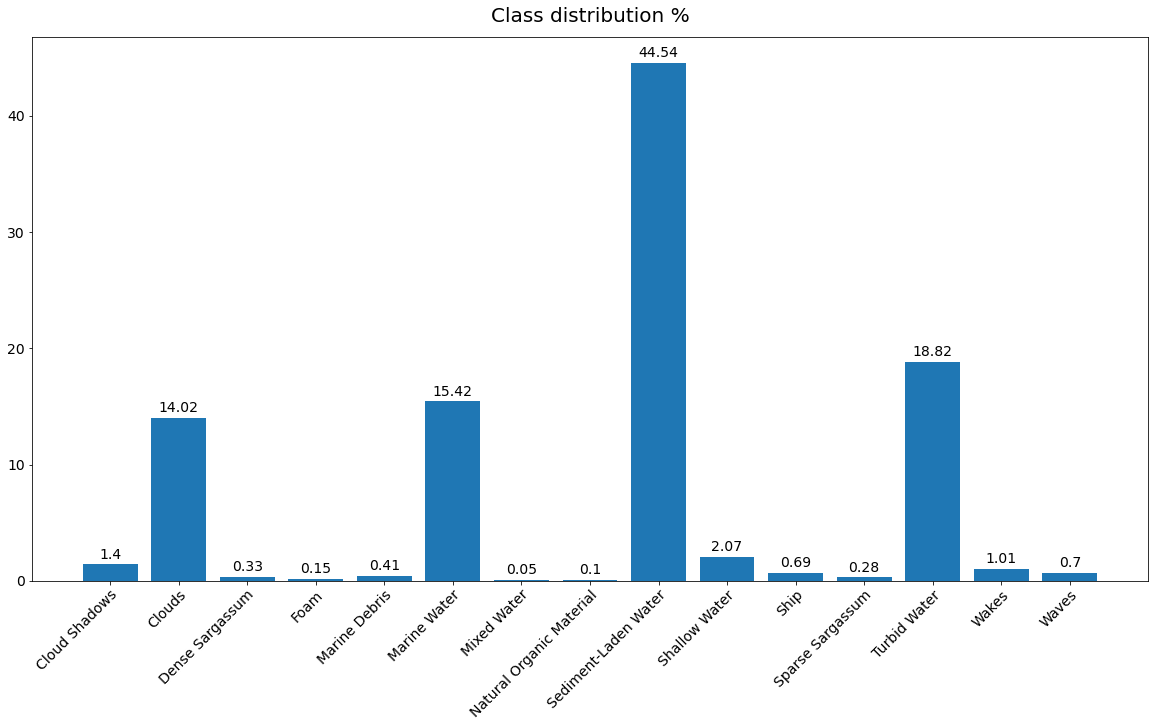

In [34]:
%matplotlib inline

tot = tile_df.loc['Total']['Total']
class_distrib = tile_df[tile_df.columns.to_list()[1:-1]].loc[['Total']]
class_distrib = class_distrib / float(tot) * 100

x = class_distrib.columns
y = class_distrib.loc['Total']

plt.figure(figsize=(20,10))
plt.bar(x, y)

for i in range(len(x)):
    plt.text(i, y[i]+0.5, round(y[i], 2), ha = 'center', fontsize=14)

plt.xticks(fontsize=14, rotation=45, ha="right", rotation_mode="anchor")
plt.yticks(fontsize=14)
plt.title("Class distribution %", fontsize=20, pad=15)
plt.show()

As a real world problem, it reveals to be highly unbalanced. The 4 most present classes (Clouds, Marine Water, Sediment-Laden Water, Turbid Water) together reach more than 90%. 

When we will do training and evaluation of classifiers we have to take this issue into account.

Here we inspect how Confidence is distribuited among classes.

In [35]:
conf_df = df1[['Confidence', 'Class']].groupby(['Confidence', 'Class']).size()
conf_df = conf_df.unstack().fillna(0)

conf_df.index = [x.name for x in Conf_map][1:]

conf_df.loc['Total'] = conf_df.sum()
conf_df = conf_df.astype(np.int32)
conf_df

Class,Cloud Shadows,Clouds,Dense Sargassum,Foam,Marine Debris,Marine Water,Mixed Water,Natural Organic Material,Sediment-Laden Water,Shallow Water,Ship,Sparse Sargassum,Turbid Water,Wakes,Waves
High,11728,117382,2797,1120,1625,129139,400,556,372917,17369,5755,2052,157612,8487,4865
Moderate,0,9,0,90,1231,16,9,201,0,0,48,290,0,3,121
Low,0,9,0,15,539,0,1,107,20,0,0,15,0,0,841
Total,11728,117400,2797,1225,3395,129155,410,864,372937,17369,5803,2357,157612,8490,5827


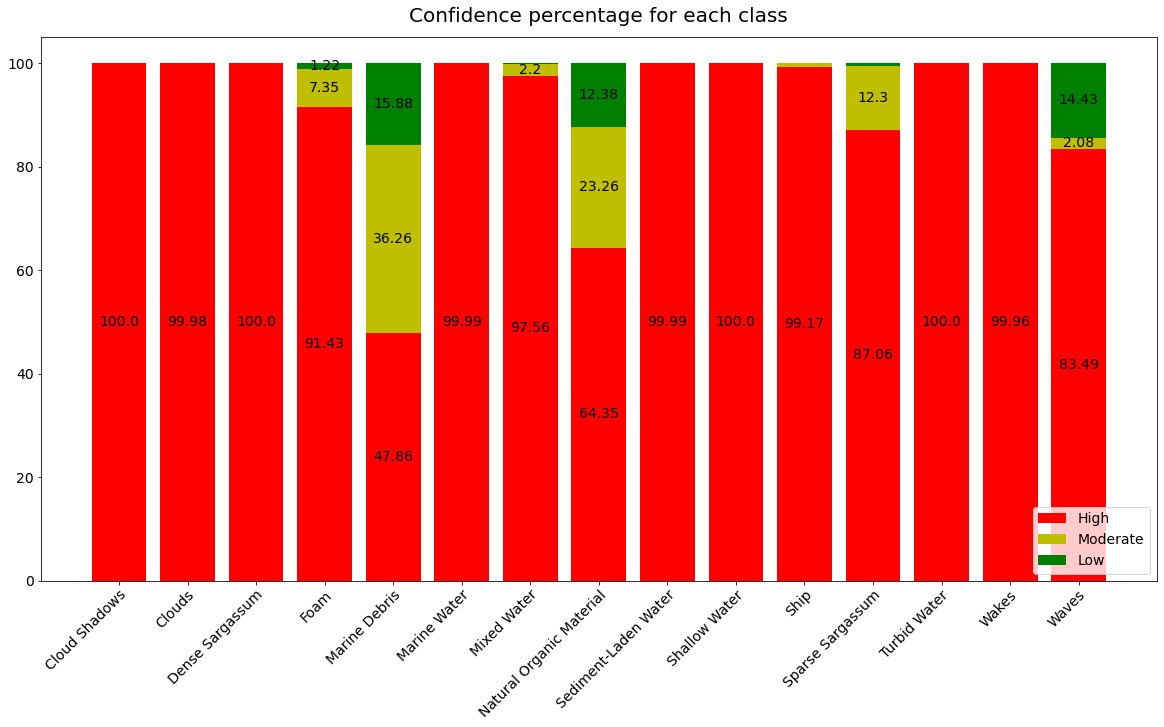

In [36]:
conf_df.loc['H_%'] = conf_df.loc['High'] / conf_df.loc['Total'] \
    .astype(np.float32) * 100
conf_df.loc['M_%'] = conf_df.loc['Moderate'] / conf_df.loc['Total'] \
    .astype(np.float32) * 100
conf_df.loc['L_%'] = conf_df.loc['Low'] / conf_df.loc['Total'] \
    .astype(np.float32) * 100

indices = conf_df.T.index
high = conf_df.T['H_%']
mod = conf_df.T['M_%']
low = conf_df.T['L_%']

plt.figure(figsize=(20,10))
plt.bar(indices, high, color='r')
plt.bar(indices, mod, bottom=high, color='y')
plt.bar(indices, low, bottom=high+mod, color='g')

th = 0.9
for i in range(len(indices)):
    if high[i] > th:
        plt.text(i, high[i]/2, round(high[i], 2), 
                 ha = 'center', va = 'center', fontsize=14)
    if mod[i] > th:
        plt.text(i, mod[i]/2 + high[i], round(mod[i], 2), 
                 ha = 'center', va = 'center', fontsize=14)
    if low[i] > th:
        plt.text(i, low[i]/2 + high[i] + mod[i], round(low[i], 2), 
                 ha = 'center', va = 'center', fontsize=14)

plt.xticks(fontsize=14, rotation=45, ha="right", rotation_mode="anchor")
plt.yticks(fontsize=14)
plt.legend(['High', 'Moderate', 'Low'], loc='lower right', fontsize=14)
plt.title("Confidence percentage for each class", fontsize=20, pad=15)
plt.ylim([0, 105])
plt.show()

Marine Debris and Natural Organic Material are the most ambiguous classes. Only half of pixels annotated as Marine Debris have a High Confidence. This means that for the other half we are less sure to deal with Marine Debris. Whereas, the other categories are almost 100% represented by High Confidence.

At training time, we have to associate a weight related to the Confidence level for each sample.

Below two more graphs are shown. The first is a collection of histogram, one for each feature. The second one describes the correlation between each possible couple of features.

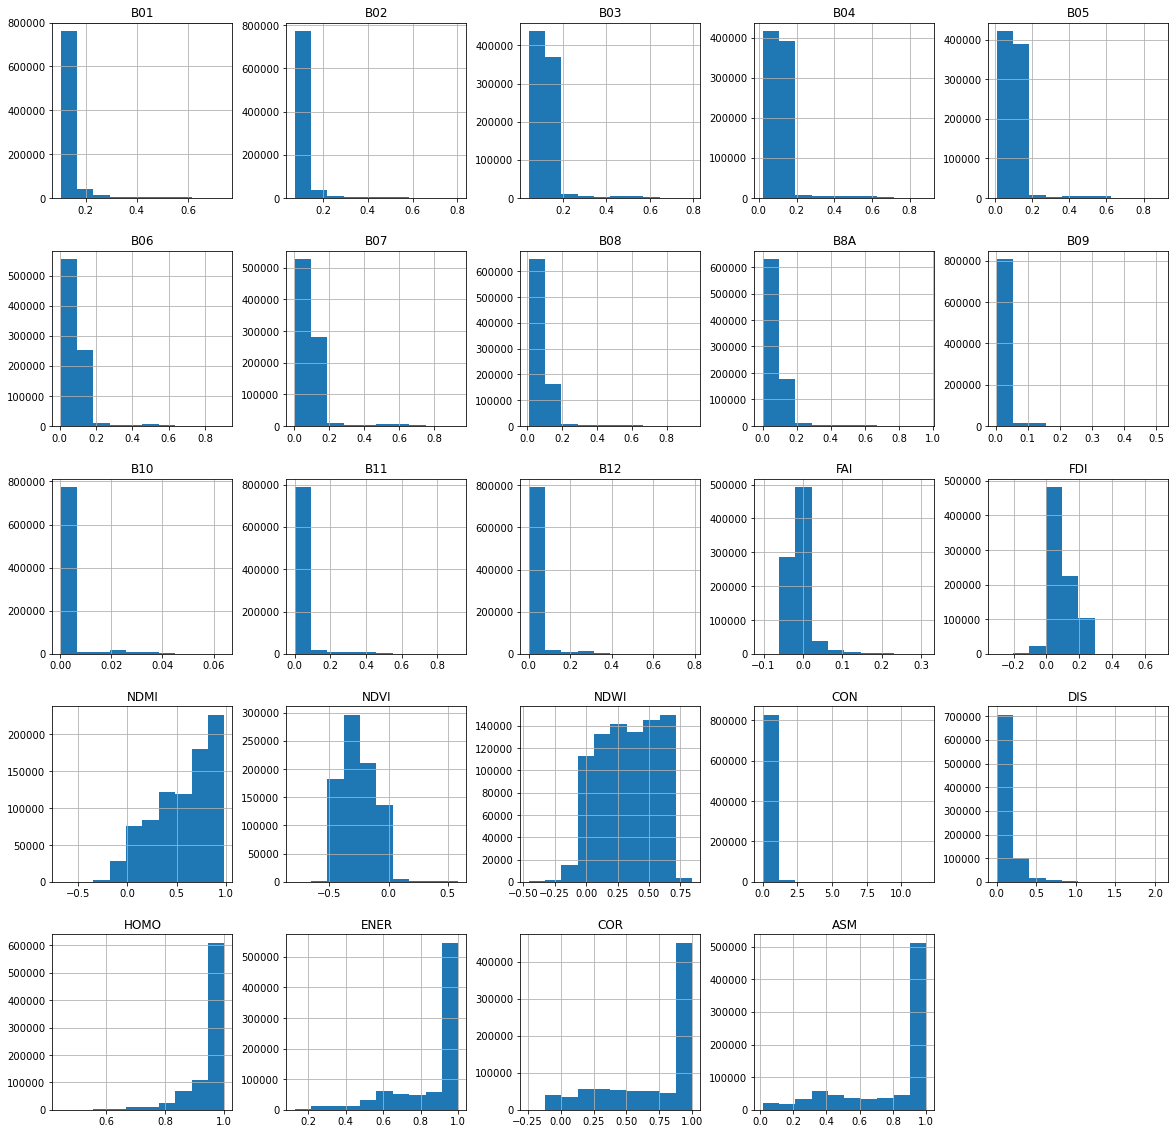

In [37]:
pd.DataFrame.hist(df1[df1.columns.to_list()[:-4]], figsize=(20,20));

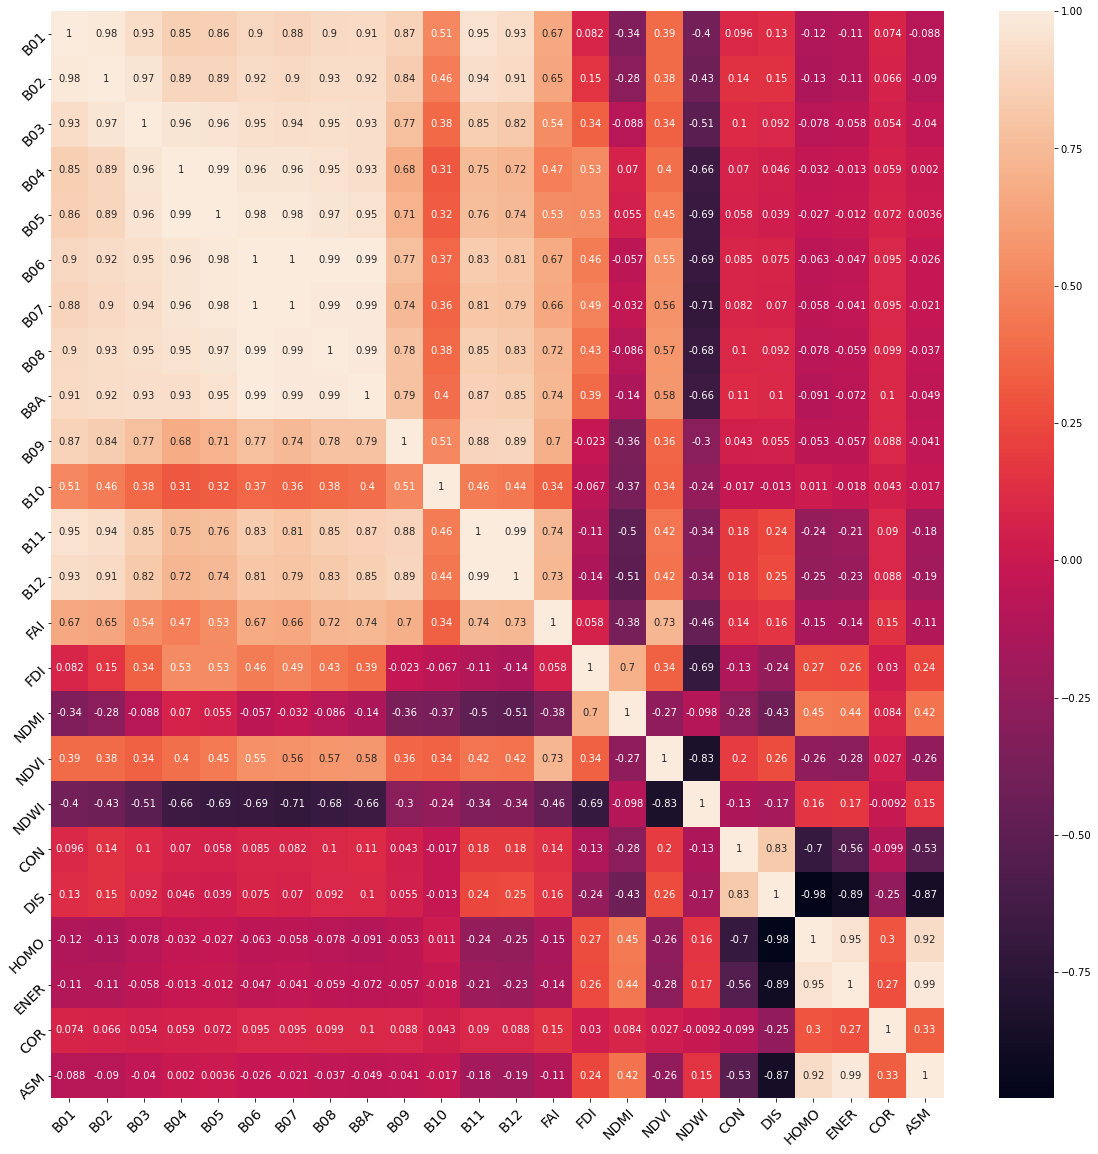

In [38]:
corr = df1[df1.columns.to_list()[:-4]].corr()

fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(corr, annot=True, ax=ax);
plt.xticks(fontsize=14, rotation=45, ha="right", rotation_mode="anchor")
plt.yticks(fontsize=14, rotation=45, ha="right", rotation_mode="anchor")
plt.show()

In [39]:
data_df = df1[df1.columns.to_list()[:-4]].copy()
features = data_df.columns.tolist()[:-1]

data_df

,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B09,...,NDMI,NDVI,NDWI,CON,DIS,HOMO,ENER,COR,ASM,Class
0,0.1703,0.1440,0.1101,0.0751,0.0661,0.0652,0.0661,0.0559,0.0617,0.0161,...,0.132725,-0.146565,0.326506,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,Wakes
1,0.1703,0.1462,0.1126,0.0787,0.0661,0.0652,0.0661,0.0589,0.0617,0.0161,...,0.158309,-0.143895,0.313120,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,Wakes
2,0.1703,0.1472,0.1125,0.0821,0.0661,0.0651,0.0669,0.0592,0.0619,0.0161,...,0.163065,-0.162067,0.310425,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,Wakes
3,0.1703,0.1458,0.1119,0.0775,0.0659,0.0608,0.0605,0.0578,0.0582,0.0161,...,0.188078,-0.145602,0.318798,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,Wakes
4,0.1703,0.1444,0.1142,0.0794,0.0661,0.0651,0.0669,0.0582,0.0619,0.0161,...,0.154762,-0.154070,0.324826,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,Wakes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
837372,0.1380,0.1082,0.0752,0.0499,0.0432,0.0403,0.0418,0.0352,0.0384,0.0056,...,0.150327,-0.172738,0.362319,0.026709,0.026709,0.986645,0.973474,-0.013535,0.947651,Marine Water
837373,0.1380,0.1082,0.0712,0.0501,0.0432,0.0403,0.0418,0.0341,0.0384,0.0056,...,0.134775,-0.190024,0.352327,0.026709,0.026709,0.986645,0.973474,-0.013535,0.947651,Marine Water
837374,0.1379,0.1096,0.0747,0.0494,0.0431,0.0406,0.0419,0.0359,0.0356,0.0056,...,0.169381,-0.158265,0.350814,0.026709,0.026709,0.986645,0.973474,-0.013535,0.947651,Marine Water
837375,0.1379,0.1077,0.0735,0.0499,0.0431,0.0406,0.0419,0.0350,0.0356,0.0056,...,0.157025,-0.175501,0.354839,0.026709,0.026709,0.986645,0.973474,-0.013535,0.947651,Marine Water


## 4.   Model selection

Samples are splitted into train and test set. Since the unbalanced nature of the problem, the split is stratified. This means that we keep the class distribution in train and test partitions. We also compute a weight for each sample based on Confidence level.

In [40]:
# Separate the class from the attributes
X = data_df.drop(['Class'], axis = 1).values
y = data_df.Class.values

# Calculate weights for each sample based on Confidence Level
w = (1/df1['Confidence']).astype(np.float32).values

labels = np.unique(y)

# Separate data into Train and Test sets
X_train, X_test, y_train, y_test, w_train, w_test = \
    train_test_split(X, 
                     y, 
                     w, 
                     test_size=0.3, 
                     random_state=random_state, 
                     stratify=y)

print("There are {} samples in the training dataset".format(X_train.shape[0]))
print("There are {} samples in the testing dataset".format(X_test.shape[0]))
print("Each sample has {} features".format(X_train.shape[1]))

There are 586158 samples in the training dataset
There are 251211 samples in the testing dataset
Each sample has 24 features


Here we set the parameters to be explored by `GridSearchCV`. We decide to perform a search among some of the most famous models: `DecisionTreeClassifier`, `RandomForestClassifier`, `AdaBoostClassifier`, `HistGradientBoostingClassifier`. 

We want to give more importance to minority classes such as Marine Debris. We can achieve this goal by selecting `f1_macro` as scoring function. By doing so, the global performance is more penalised if the minority classes have bad performance.

In [41]:
# List of models to be evaluated
model_lbls = [
              'dt',
             'rfc',
             'ada',
             'hgb'
            ]

# Set the parameters to be explored by the grid for each classifier
tuned_param_dt = [{'max_depth': list(range(10,26))}]
tuned_param_rfc =[{'max_depth': list(range(10,26))}]
tuned_param_ada = [{'n_estimators': [75, 100, 125],
    'learning_rate': [1., 0.1, 0.01]}]
tuned_param_hgb = [{'max_iter': [75, 100, 125],
    'learning_rate': [1., 0.1, 0.01]}]

# Set the models to be fitted specifying name, 
# estimator and parameter structure
models = {
    'dt': {'name': 'Decision Tree       ',
           'estimator': DecisionTreeClassifier(random_state=random_state), 
           'param': tuned_param_dt,
          },
    'rfc':{'name': 'Random Forest       ',
           'estimator': RandomForestClassifier(
               n_estimators=125, 
               bootstrap=False,
               random_state=random_state, 
               n_jobs=-1, 
               class_weight='balanced_subsample'),
           'param': tuned_param_rfc
          }, 
    'ada':{'name': 'Adaboost            ',
           'estimator': AdaBoostClassifier(random_state=random_state),
           'param': tuned_param_ada
          },
    'hgb':{'name': 'HistGradientBoosting',
           'estimator': HistGradientBoostingClassifier(
               random_state=random_state),
           'param': tuned_param_hgb
          }
}

# Scores to be explored
scores = [
          'f1_macro'
         ]

In [42]:
%matplotlib inline

def plot_confusion_matrix(cm, labels):
    """
    Utility function to plot the confusion matrix
    """
    fig, ax = plt.subplots(figsize=(15,12))
    plt.title('Confusion matrix', fontsize=20, pad=15)
    sh = sns.heatmap(data=cm, 
                     annot=True,
                     xticklabels=labels, 
                     yticklabels=labels,
                     fmt="d",
                     annot_kws={"size": 14}, 
                     ax=ax, 
                     cmap='viridis')
    plt.xticks(fontsize=14, rotation=45, ha="right", rotation_mode="anchor")
    plt.yticks(fontsize=14, rotation=45, ha="right", rotation_mode="anchor")
    plt.xlabel("Predicted label", fontsize=14)
    plt.ylabel("True label", fontsize=14)
    plt.show()

def print_results(model):
    """
    Given a model, prints mean score, std score, mean fit time 
    on train set and classification report, confusion matrix on test set
    """
    print("Best parameters set found on train set:")
    print()
    print(model.best_params_)
    print()
    print("Grid scores on train set:")
    print()
    means = model.cv_results_['mean_test_score']
    stds = model.cv_results_['std_test_score']
    params = model.cv_results_['params']
    times = model.cv_results_['mean_fit_time']
    for mean, std, params_tuple, time in zip(means, stds, params, times):
        print("%0.3f (+/-%0.03f) for %r; mean fit time: %0.3f s"
              % (mean, std * 2, params_tuple, time))
    print()
    print("Detailed classification report for the best parameter set:")
    print()
    print("The model is trained on the full train set.")
    print("The scores are computed on the full test set.")
    print()
    y_true, y_pred = y_test, model.predict(X_test)
    print(classification_report(y_true, y_pred))
    cm = confusion_matrix(y_true,y_pred, labels = labels)
    plot_confusion_matrix(cm, labels)
    print()

This will take a lot of time, 7-8 hours. If you set verbose>1 on `GridSearchCV` you can keep track of the process on the terminal where you launched this notebook

# Tuning hyper-parameters for f1_macro

----------------------------------------
Trying model Decision Tree       
Fitting 10 folds for each of 16 candidates, totalling 160 fits
Best parameters set found on train set:

{'max_depth': 24}

Grid scores on train set:

0.720 (+/-0.014) for {'max_depth': 10}; mean fit time: 33.263 s
0.753 (+/-0.011) for {'max_depth': 11}; mean fit time: 37.101 s
0.774 (+/-0.014) for {'max_depth': 12}; mean fit time: 36.319 s
0.794 (+/-0.011) for {'max_depth': 13}; mean fit time: 35.211 s
0.814 (+/-0.016) for {'max_depth': 14}; mean fit time: 38.608 s
0.827 (+/-0.015) for {'max_depth': 15}; mean fit time: 43.069 s
0.837 (+/-0.014) for {'max_depth': 16}; mean fit time: 45.453 s
0.843 (+/-0.015) for {'max_depth': 17}; mean fit time: 45.283 s
0.849 (+/-0.014) for {'max_depth': 18}; mean fit time: 45.543 s
0.851 (+/-0.018) for {'max_depth': 19}; mean fit time: 43.944 s
0.853 (+/-0.015) for {'max_depth': 20}; mean fit time: 48.218 s
0.859 (+/-0.015) for {'max_dept

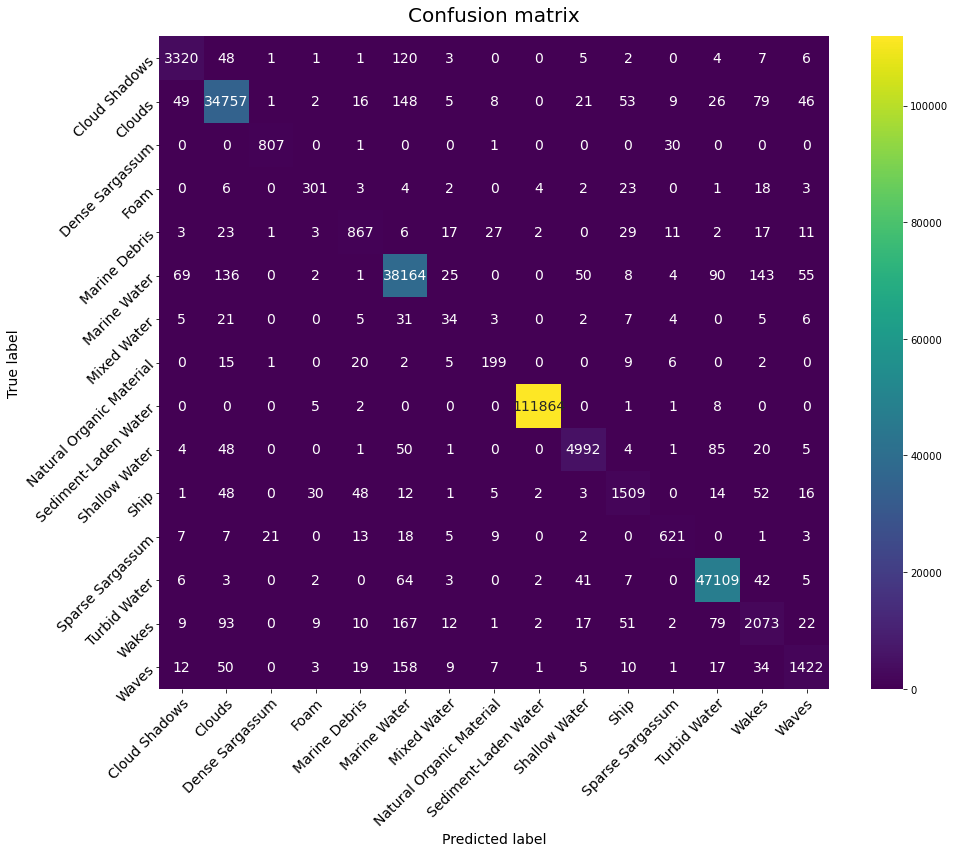


----------------------------------------
Trying model Random Forest       
Fitting 10 folds for each of 16 candidates, totalling 160 fits
Best parameters set found on train set:

{'max_depth': 22}

Grid scores on train set:

0.738 (+/-0.014) for {'max_depth': 10}; mean fit time: 575.077 s
0.771 (+/-0.012) for {'max_depth': 11}; mean fit time: 598.829 s
0.800 (+/-0.011) for {'max_depth': 12}; mean fit time: 625.388 s
0.825 (+/-0.010) for {'max_depth': 13}; mean fit time: 646.524 s
0.847 (+/-0.012) for {'max_depth': 14}; mean fit time: 663.446 s
0.872 (+/-0.011) for {'max_depth': 15}; mean fit time: 680.344 s
0.890 (+/-0.010) for {'max_depth': 16}; mean fit time: 694.254 s
0.908 (+/-0.010) for {'max_depth': 17}; mean fit time: 733.899 s
0.920 (+/-0.010) for {'max_depth': 18}; mean fit time: 762.843 s
0.930 (+/-0.013) for {'max_depth': 19}; mean fit time: 768.306 s
0.933 (+/-0.013) for {'max_depth': 20}; mean fit time: 777.604 s
0.939 (+/-0.014) for {'max_depth': 21}; mean fit time: 790.

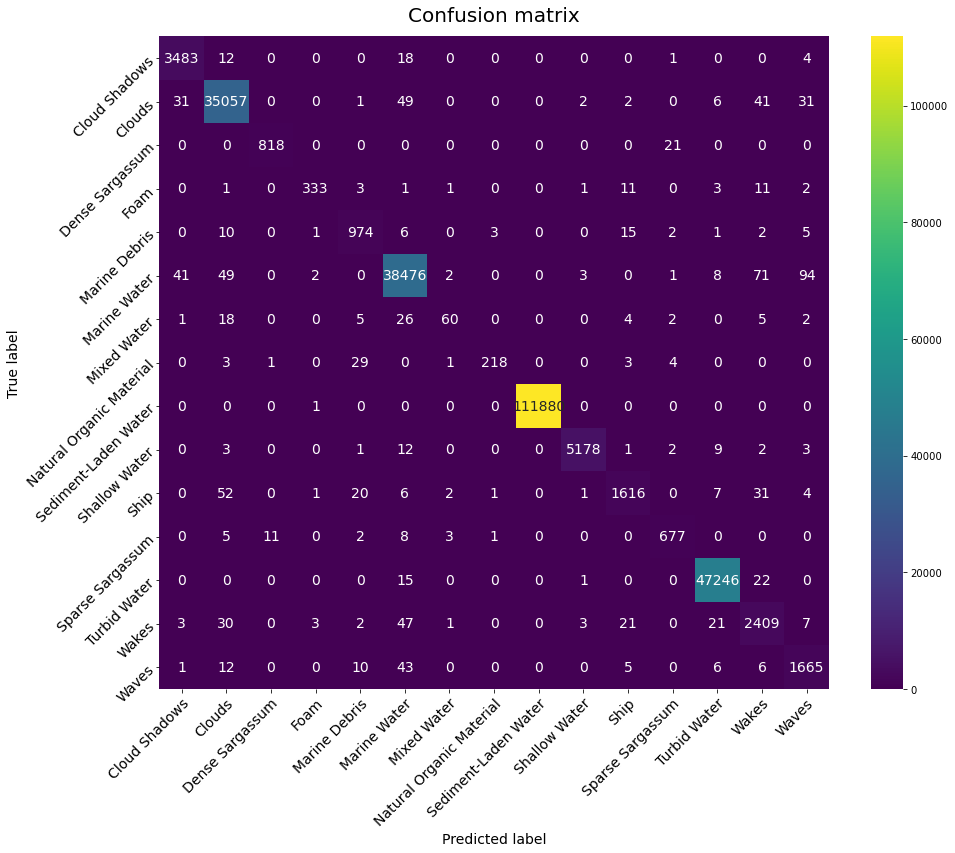


----------------------------------------
Trying model Adaboost            
Fitting 10 folds for each of 9 candidates, totalling 90 fits
Best parameters set found on train set:

{'learning_rate': 0.1, 'n_estimators': 125}

Grid scores on train set:

0.135 (+/-0.026) for {'learning_rate': 1.0, 'n_estimators': 75}; mean fit time: 545.260 s
0.167 (+/-0.012) for {'learning_rate': 1.0, 'n_estimators': 100}; mean fit time: 719.740 s
0.135 (+/-0.026) for {'learning_rate': 1.0, 'n_estimators': 125}; mean fit time: 914.818 s
0.263 (+/-0.017) for {'learning_rate': 0.1, 'n_estimators': 75}; mean fit time: 539.570 s
0.262 (+/-0.016) for {'learning_rate': 0.1, 'n_estimators': 100}; mean fit time: 728.461 s
0.271 (+/-0.016) for {'learning_rate': 0.1, 'n_estimators': 125}; mean fit time: 921.244 s
0.227 (+/-0.003) for {'learning_rate': 0.01, 'n_estimators': 75}; mean fit time: 550.218 s
0.232 (+/-0.001) for {'learning_rate': 0.01, 'n_estimators': 100}; mean fit time: 731.131 s
0.227 (+/-0.003) for {'

C:\Users\loren\anaconda3\envs\dm_project\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\loren\anaconda3\envs\dm_project\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\loren\anaconda3\envs\dm_project\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                          precision    recall  f1-score   support

           Cloud Shadows       0.00      0.00      0.00      3518
                  Clouds       0.76      0.91      0.83     35220
         Dense Sargassum       0.00      0.00      0.00       839
                    Foam       0.86      0.03      0.06       367
           Marine Debris       0.02      0.73      0.04      1019
            Marine Water       0.64      0.92      0.75     38747
             Mixed Water       0.00      0.00      0.00       123
Natural Organic Material       0.11      0.27      0.15       259
    Sediment-Laden Water       1.00      0.53      0.69    111881
           Shallow Water       0.20      0.00      0.01      5211
                    Ship       0.02      0.20      0.03      1741
        Sparse Sargassum       0.80      0.39      0.53       707
            Turbid Water       0.96      0.81      0.88     47284
                   Wakes       0.15      0.04      0.06      2547
         

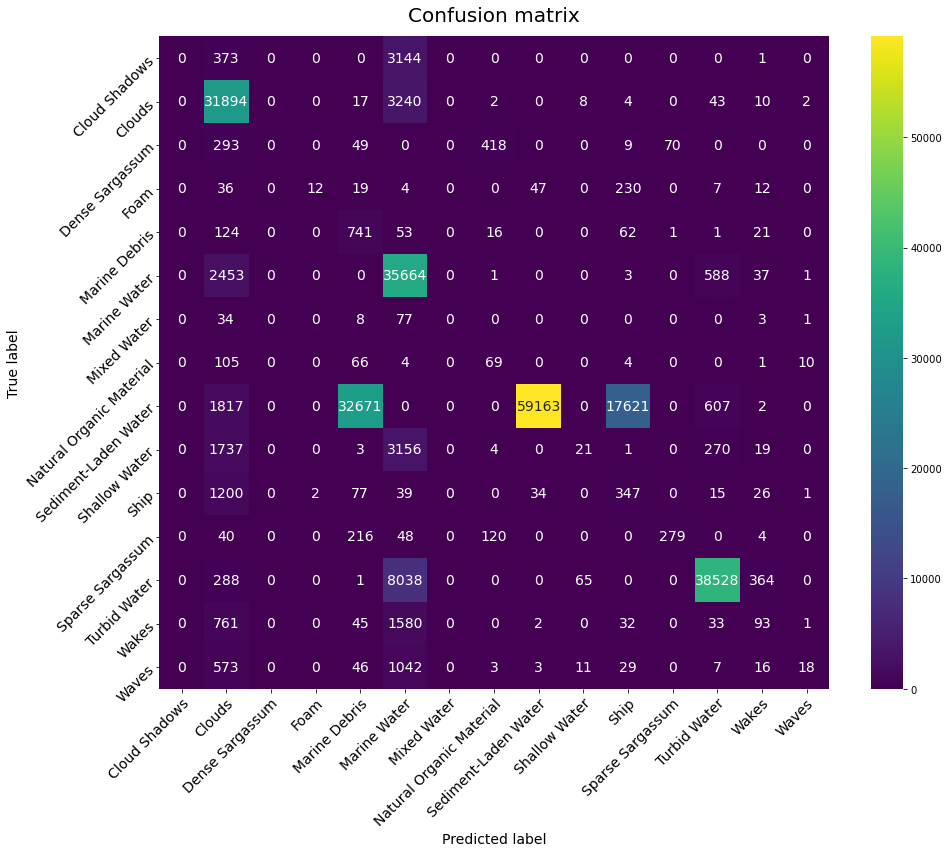


----------------------------------------
Trying model HistGradientBoosting
Fitting 10 folds for each of 9 candidates, totalling 90 fits
Best parameters set found on train set:

{'learning_rate': 0.01, 'max_iter': 125}

Grid scores on train set:

0.135 (+/-0.082) for {'learning_rate': 1.0, 'max_iter': 75}; mean fit time: 42.956 s
0.135 (+/-0.082) for {'learning_rate': 1.0, 'max_iter': 100}; mean fit time: 43.523 s
0.135 (+/-0.082) for {'learning_rate': 1.0, 'max_iter': 125}; mean fit time: 44.639 s
0.761 (+/-0.027) for {'learning_rate': 0.1, 'max_iter': 75}; mean fit time: 46.894 s
0.761 (+/-0.027) for {'learning_rate': 0.1, 'max_iter': 100}; mean fit time: 48.165 s
0.761 (+/-0.027) for {'learning_rate': 0.1, 'max_iter': 125}; mean fit time: 47.300 s
0.825 (+/-0.020) for {'learning_rate': 0.01, 'max_iter': 75}; mean fit time: 310.928 s
0.840 (+/-0.018) for {'learning_rate': 0.01, 'max_iter': 100}; mean fit time: 412.973 s
0.852 (+/-0.016) for {'learning_rate': 0.01, 'max_iter': 125}; m

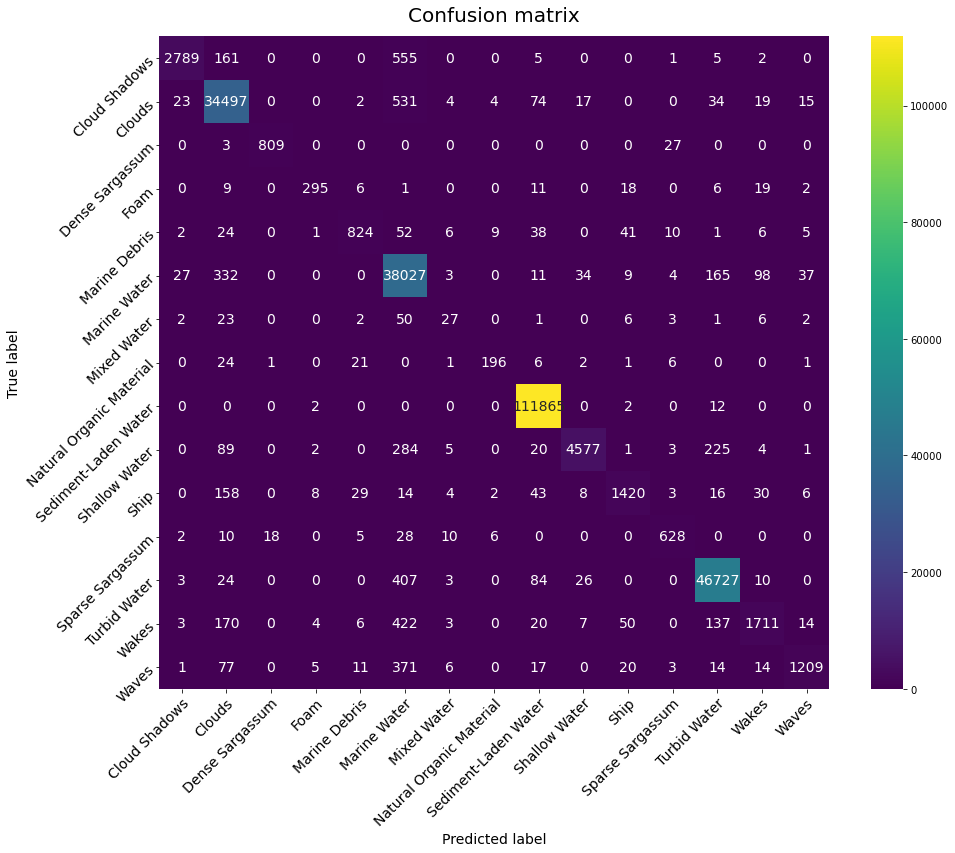


Summary of results for f1_macro
Estimator
Decision Tree       	 - score: 0.86
Random Forest       	 - score: 0.94
Adaboost            	 - score: 0.27
HistGradientBoosting	 - score: 0.85
Wall time: 7h 27min 28s


In [43]:
# %%time

# results_short = {}

# for score in scores:
#     print('='*40)
#     print("# Tuning hyper-parameters for %s" % score)
#     print()

#     for m in model_lbls:
#         print('-'*40)
#         print("Trying model {}".format(models[m]['name']))
#         cv = StratifiedKFold(n_splits=10, 
#                              shuffle=True, 
#                              random_state=random_state)
        
#         clf = GridSearchCV(models[m]['estimator'], 
#                            models[m]['param'], 
#                            cv=cv,
#                            scoring=score, 
#                            return_train_score = False,
#                            n_jobs = -1,
#                            verbose=3)
        
#         clf.fit(X_train, y_train, sample_weight=w_train)
#         print_results(clf)
#         results_short[m] = clf.best_score_
        
#     print("Summary of results for {}".format(score))
#     print("Estimator")
#     for m in results_short.keys():
#         print("{}\t - score: {:4.2}" \
#               .format(models[m]['name'], results_short[m]))

Random Forest and Decision Tree achieve the highest score, respectively 0.94 and 0.86. Adaboost has the worst performace, 0.27. I guess it needs much more estimators to work properly. 

From now on we consider just the Random Forest model.

## 5.   Training and evaluation

Now we train and evaluate the best model with optimal parameters. 

In [44]:
# This is the best parameter found by GridSearchCV
max_depth_rf = 22

In [45]:
model_name = 'rf.pkl'
model_path = os.path.join(RESULTS_FOLDER, model_name)

Training time
Wall time: 1min 59s
Scores on train set
                          precision    recall  f1-score   support

           Cloud Shadows       0.99      1.00      1.00      8210
                  Clouds       1.00      1.00      1.00     82180
         Dense Sargassum       1.00      1.00      1.00      1958
                    Foam       1.00      1.00      1.00       858
           Marine Debris       1.00      1.00      1.00      2376
            Marine Water       1.00      1.00      1.00     90408
             Mixed Water       0.99      1.00      0.99       287
Natural Organic Material       1.00      1.00      1.00       605
    Sediment-Laden Water       1.00      1.00      1.00    261056
           Shallow Water       1.00      1.00      1.00     12158
                    Ship       1.00      1.00      1.00      4062
        Sparse Sargassum       1.00      1.00      1.00      1650
            Turbid Water       1.00      1.00      1.00    110328
                   Wa

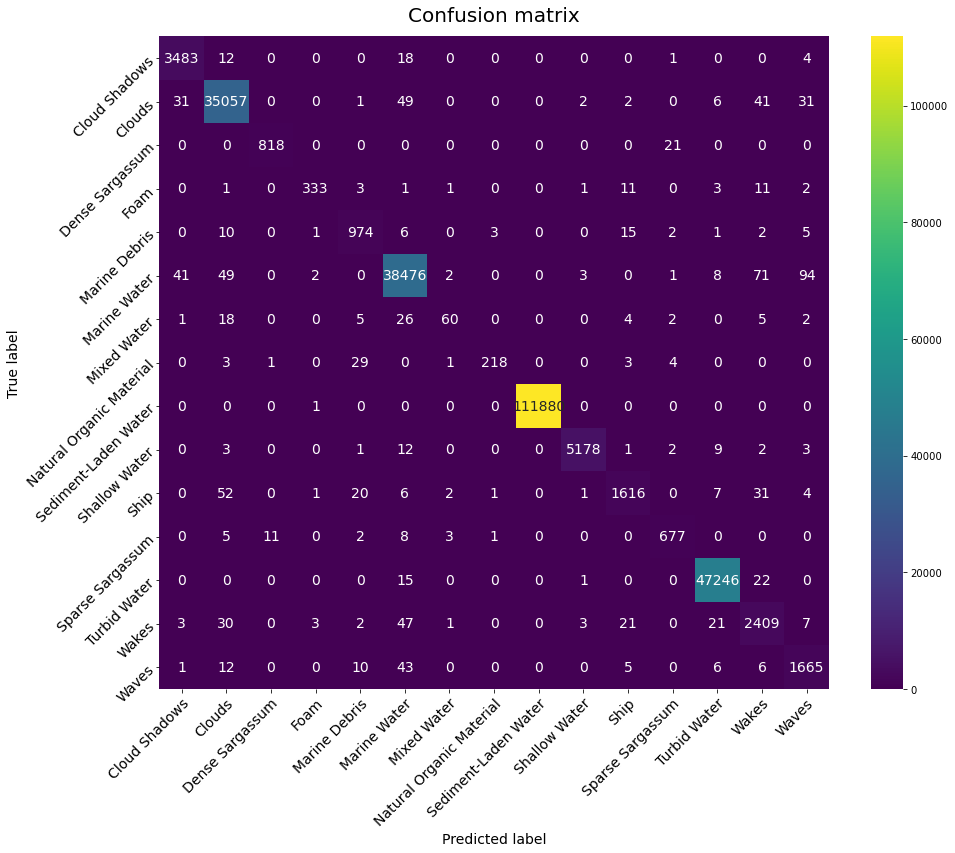

In [46]:
%matplotlib inline

rf = RandomForestClassifier(n_estimators=125,
                            bootstrap=False,
                            max_depth=max_depth_rf, 
                            random_state=random_state, 
                            n_jobs=-1, 
                            class_weight='balanced_subsample')

# Training
print("Training time")
%time rf.fit(X_train, y_train, sample_weight=w_train)
print('Scores on train set')
print(classification_report(y_train, rf.predict(X_train)))
print()

# Save (and Load) the model
joblib.dump(rf, model_path)
# rf = joblib.load(model_path)

# Test
print("Test time")
%time y_true, y_pred = y_test, rf.predict(X_test)
print('Scores on test set')
print(classification_report(y_true, y_pred))
cm = confusion_matrix(y_true,y_pred, labels = labels)
plot_confusion_matrix(cm, labels)

In [47]:
# Computation of auc_score

y_prob = rf.predict_proba(X_test)

# OVO Computes the average AUC of all possible pairwise combinations  
# of classes.
macro_roc_auc_ovo = roc_auc_score(
    y_test, 
    y_prob, 
    multi_class="ovo", 
    average="macro"
)

print("One-vs-One ROC AUC scores: {:.6f}".format(macro_roc_auc_ovo))

One-vs-One ROC AUC scores: 0.997411


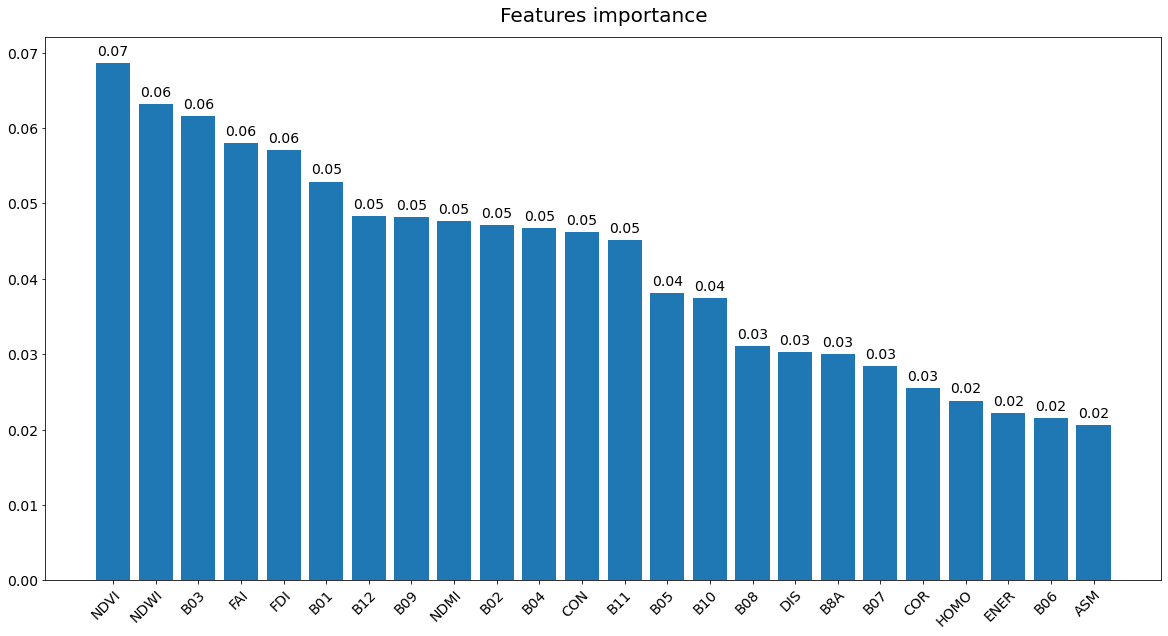

In [48]:
y_val, x_val = zip(*sorted(zip(rf.feature_importances_, features))[::-1])
feature_importance_rf = list(x_val)

plt.figure(figsize=(20,10))
plt.bar(x_val, y_val)

for i in range(len(x_val)):
    plt.text(i, y_val[i]+0.001, round(y_val[i], 2), ha = 'center', fontsize=14)

plt.xticks(fontsize=14, rotation=45, ha="right", rotation_mode="anchor")
plt.yticks(fontsize=14)
plt.title("Features importance", fontsize=20, pad=15)
plt.show()

### Feature selection

Let's try feature selection. Maybe we can improve the performance of the model. Below we try to keep just 10 features using two techniques: Principal Component Analysis and Recursive Feature Elimination.

In [49]:
# Number of features to keep
n=10

scoring = 'f1_macro'
scores_rf = {}
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)

In [50]:
%time sc = cross_val_score(rf, X, y, scoring=scoring, cv = cv)

scores_rf = {'full' : np.round(np.mean(sc), 2)}
print("The CV {} with full data is {}"\
      .format(scoring, scores_rf['full']))

Wall time: 20min 45s
The CV f1_macro with full data is 0.95


#### PCA

In [51]:
# Feature extraction
pca = PCA(n_components=n)
%time fit_pca = pca.fit(X)

# Summarize components
print("Explained Variance:", fit_pca.explained_variance_ratio_)
X_pca = fit_pca.transform(X)

Wall time: 1.77 s
Explained Variance: [0.40459353 0.19437268 0.15309059 0.12615296 0.07524314 0.03611987
 0.00488228 0.0027156  0.00114633 0.00059243]


In [52]:
%time sc_pca = cross_val_score(rf, X_pca, y, scoring=scoring, cv = cv)
scores_rf['PCA'] = np.round(np.mean(sc_pca), 2)
print("The CV {} with 'PCA' reduced data is {}" \
      .format(scoring, scores_rf['PCA']))

Wall time: 34min 13s
The CV f1_macro with 'PCA' reduced data is 0.83


#### RFE

In [53]:
# Utility Dataframe used to get feature names out of RFE
X_df = pd.DataFrame(X, columns=features)

In [54]:
# Feature extraction
rfe = RFE(estimator=DecisionTreeClassifier(max_depth=24, 
                                           random_state=random_state), 
          n_features_to_select=n)
%time fit_rfe = rfe.fit(X_df, y, sample_weight=w)
X_rfe = fit_rfe.transform(X_df)

# Summarize components
print("Feature Ranking: ", fit_rfe.ranking_)
print("Selected Features: ", fit_rfe.support_)
print("Selected Feature names: ", fit_rfe.get_feature_names_out())

Wall time: 5min 5s
Feature Ranking:  [ 1  1  1  1  8  1 12  5 13  1  2  6 11  1  1  3 14  1  1 15  9  7  4 10]
Selected Features:  [ True  True  True  True False  True False False False  True False False
 False  True  True False False  True  True False False False False False]
Selected Feature names:  ['B01' 'B02' 'B03' 'B04' 'B06' 'B09' 'FAI' 'FDI' 'NDWI' 'CON']


In [55]:
%time sc_rfe = cross_val_score(rf, X_rfe, y, scoring=scoring, cv = cv)
scores_rf['RFE'] = np.round(np.mean(sc), 2)
print("The CV {} with 'RFE' reduced data is {}" \
      .format(scoring, scores_rf['RFE']))

Wall time: 18min 40s
The CV f1_macro with 'RFE' reduced data is 0.95


In [56]:
print('Random forest {} scores'.format(scoring))
print(scores_rf)

Random forest f1_macro scores
{'full': 0.95, 'PCA': 0.83, 'RFE': 0.95}


There is no increment in performance, but with RFE we obtain a similar score with just 10 features. Anyway, this could lead to a faster features extraction and a faster training of the model.

### Water Superclass

Here we try to train and evaluate the model by considering a Water Superclass. Some of MARIDA classes can be easily integrated into the concept of water even though they are slighlty different. So, we decide to aggregate Mixed Water, Wakes, Cloud Shadows and Waves into Water class.

In [57]:
# Aggregate classes to Water Superclass
agg_to_water = ["Mixed Water", "Wakes", "Cloud Shadows", "Waves"]

data_ws = data_df.copy()
for a in agg_to_water:
    data_ws.loc[data_ws['Class'] == a, 'Class'] = "Marine Water"

In [58]:
# Separate the class from the attributes
X_ws = data_ws.drop(['Class'], axis = 1).values
y_ws = data_ws.Class.values

# Calculate weights for each sample based on Confidence Level
w_ws = (1/df1['Confidence']).astype(np.float32).values

labels_ws = np.unique(y_ws)

X_train_ws, X_test_ws, y_train_ws, y_test_ws, w_train_ws, w_test_ws = \
    train_test_split(X_ws, 
                     y_ws, 
                     w_ws, 
                     test_size=0.3,
                     random_state=random_state, 
                     stratify=y_ws)

print("Unique classes are {}: {}".format(len(labels_ws), labels_ws))

Unique classes are 11: ['Clouds' 'Dense Sargassum' 'Foam' 'Marine Debris' 'Marine Water'
 'Natural Organic Material' 'Sediment-Laden Water' 'Shallow Water' 'Ship'
 'Sparse Sargassum' 'Turbid Water']


In [59]:
model_name_ws = 'rf_ws.pkl'
model_path_ws = os.path.join(RESULTS_FOLDER, model_name_ws)

Training time
Wall time: 2min 9s
Scores on train set
                          precision    recall  f1-score   support

                  Clouds       1.00      1.00      1.00     82180
         Dense Sargassum       1.00      1.00      1.00      1958
                    Foam       1.00      1.00      1.00       858
           Marine Debris       1.00      1.00      1.00      2376
            Marine Water       1.00      1.00      1.00    108927
Natural Organic Material       1.00      1.00      1.00       605
    Sediment-Laden Water       1.00      1.00      1.00    261056
           Shallow Water       1.00      1.00      1.00     12158
                    Ship       1.00      1.00      1.00      4062
        Sparse Sargassum       1.00      1.00      1.00      1650
            Turbid Water       1.00      1.00      1.00    110328

                accuracy                           1.00    586158
               macro avg       1.00      1.00      1.00    586158
            weighted 

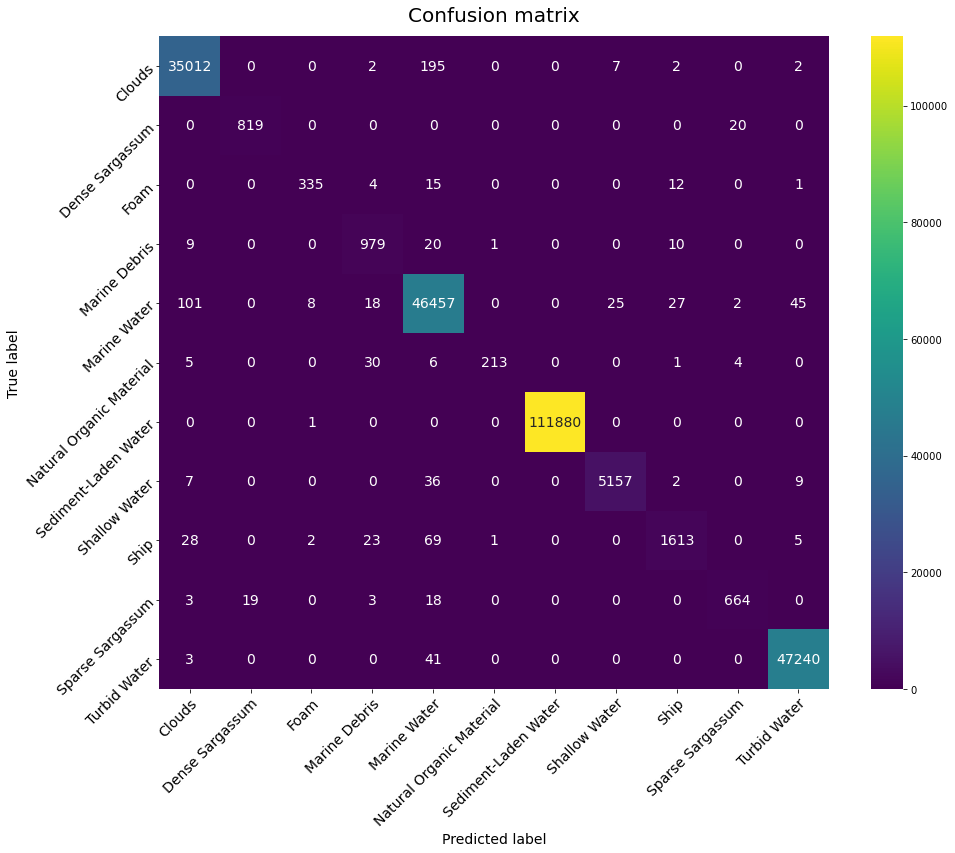

In [60]:
%matplotlib inline

rf_ws = RandomForestClassifier(n_estimators=125,
                            bootstrap=False,
                            max_depth=max_depth_rf, 
                            random_state=random_state, 
                            n_jobs=-1, 
                            class_weight='balanced_subsample')

# Training
print("Training time")
%time rf_ws.fit(X_train_ws, y_train_ws, sample_weight=w_train_ws)
print('Scores on train set')
print(classification_report(y_train_ws, rf_ws.predict(X_train_ws)))
print()

# Save (and Load) the model
joblib.dump(rf_ws, model_path_ws)
# rf_ws = joblib.load(model_path_ws)

# Test
print("Test time")
%time y_true_ws, y_pred_ws = y_test_ws, rf_ws.predict(X_test_ws)
print('Scores on test set')
print(classification_report(y_true_ws, y_pred_ws))
cm_ws = confusion_matrix(y_true_ws, y_pred_ws, labels=labels_ws)
plot_confusion_matrix(cm_ws, labels_ws)

In this case the performance is slightly higher reaching 0.97 on Test set.

## 6.   Prediction and visualization of the results

Now we show how to make prediction on an existing EOPach. We define the tasks, the workflow and finally we visualize the result.

In [61]:
def extract_features(eopatch):
    """
    Utility function to extract features from an EOPatch
    """
    
    features = eopatch.data["BANDS"]

    FAI = eopatch.data['FAI']
    FDI = eopatch.data['FDI']
    NDMI = eopatch.data['NDMI']
    NDVI = eopatch.data['NDVI']
    NDWI = eopatch.data['NDWI']

    t, w1, h, f = features.shape
    if t==0:
        raise Exception('ERROR! Patch with empy data')
    
    features = np.moveaxis(features, 0, 2).reshape(w1 * h, t * f)
    t, w1, h, f = FAI.shape
    FAI = np.moveaxis(FAI, 0, 2).reshape(w1 * h, t * f)
    FDI = np.moveaxis(FDI, 0, 2).reshape(w1 * h, t * f)
    NDMI = np.moveaxis(NDMI, 0, 2).reshape(w1 * h, t * f)
    NDVI = np.moveaxis(NDVI, 0, 2).reshape(w1 * h, t * f)
    NDWI = np.moveaxis(NDWI, 0, 2).reshape(w1 * h, t * f)
    features = np.concatenate((features, FAI, FDI, NDMI, NDVI, NDWI), 
                                  axis=1)

    data = np.full((1, w1 * h), 1)
    if 'CLASS' in eopatch.label:
        data = eopatch.label['CLASS']    

    filter_ = np.squeeze(data) > 0
    fcl_features = features[filter_]
    return fcl_features

### Prediction EOTask

In [62]:
class PredictPatchTask(EOTask):
    """
    Task to make model predictions on a patch. Provide the model 
    and the feature, and the output names of labels
    """

    def __init__(self, model, predicted_labels_name):
        self.model = model
        self.predicted_labels_name = predicted_labels_name

    def execute(self, eopatch):
        
        bands = eopatch.data['BANDS']
        t, w, h, f = bands.shape
        
        eo_features = extract_features(eopatch)
        texture_features = extract_texture_features(eopatch)
        features = np.hstack((eo_features, texture_features))
        
        data = np.full((1, w * h), 1)
        out = np.full((1, w * h), 0)
        if 'CLASS' in eopatch.label:
            data = eopatch.label['CLASS']
        
        predicted_labels = self.model.predict(features)
        out[data>0] = [MDC(x).id for x in predicted_labels]
        out = out.reshape(w, h)
        out = out[..., np.newaxis]
        eopatch[(FeatureType.MASK_TIMELESS, self.predicted_labels_name)] = out

        return eopatch

### Workflow definition

In [63]:
# We run the prediction with the full class model. If you want to try the Water
# Superclass model, set WS to True
WS = False

rf = joblib.load(model_path) if not WS else joblib.load(model_path_ws)

In [64]:
# Load existing EOPatch(es)
load = LoadTask(EOPATCH_FOLDER)

# Predict
predict = PredictPatchTask(rf, "LBL_RF")

# Save
save = SaveTask(EOPATCH_FOLDER, 
                overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

# Define the workflow
workflow_nodes = linearly_connect_tasks(load, predict, save)
workflow = EOWorkflow(workflow_nodes)

### Run the prediction

In [65]:
# Here we just selected one EOPatch as an example.
eopatch_path = os.path.join(EOPATCH_FOLDER, 
                                    'eopatch_S2_1-12-19_48MYU_0')

In [66]:
# Create a list of execution arguments for each patch
execution_args = []
p = os.path.basename(eopatch_path)
execution_args.append(
    {
        workflow_nodes[0]: {"eopatch_folder": f"{p}"},
        workflow_nodes[2]: {"eopatch_folder": f"{p}"},
    }
)

# Run the executor
executor = EOExecutor(workflow, execution_args)
executor.run(workers=1, multiprocess=False)
executor.make_report()

failed_ids = executor.get_failed_executions()
if failed_ids:
    raise RuntimeError(
        f"Execution failed EOPatches with IDs:\n{failed_ids}\n"
        f"For more info check report at {executor.get_report_path()}"
    )

  0%|          | 0/1 [00:00<?, ?it/s]

### Visual inspection

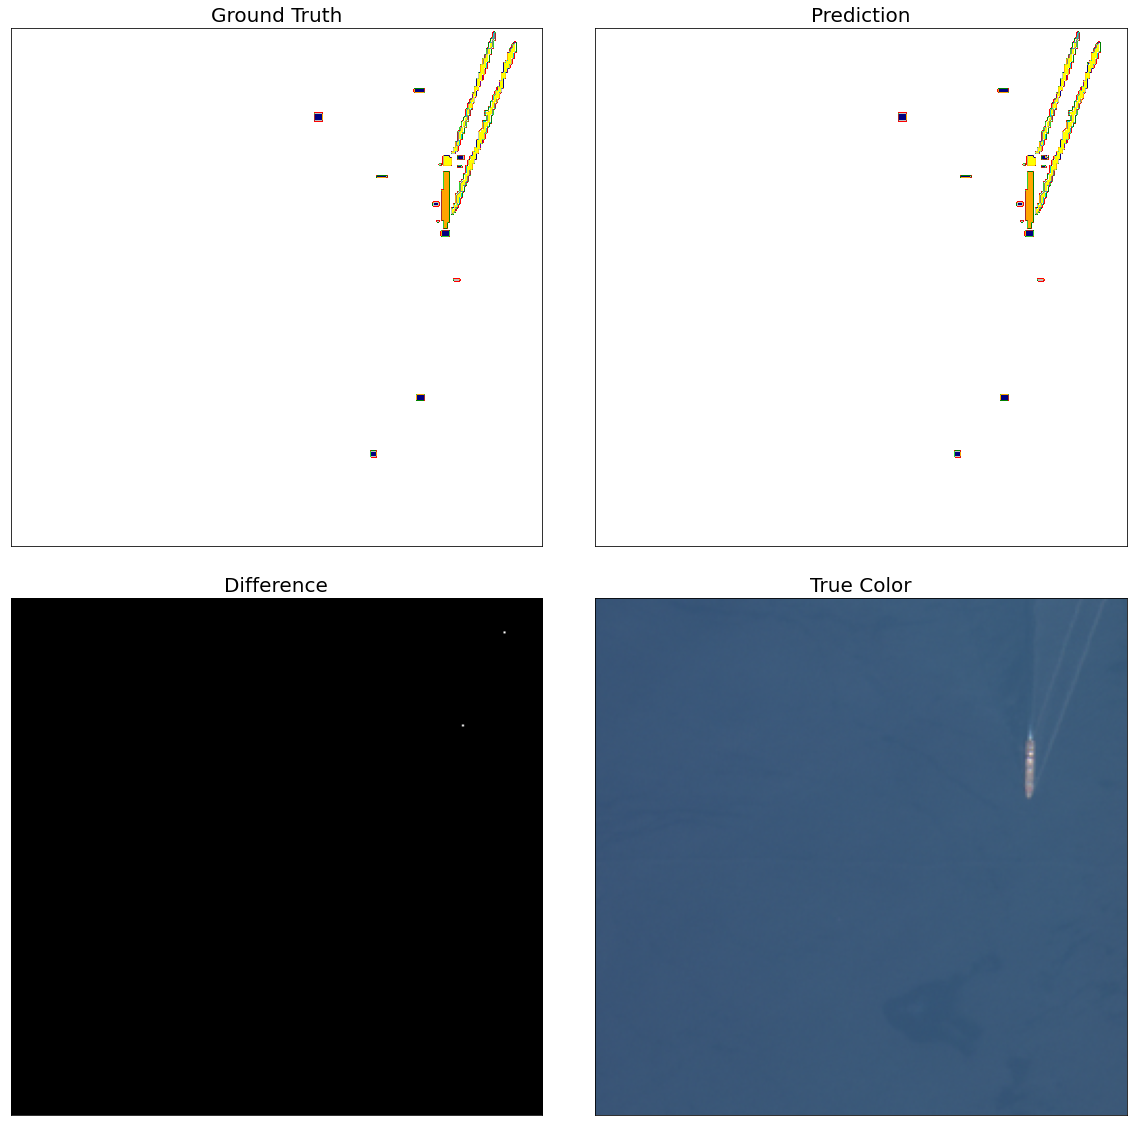

In [67]:
%matplotlib inline

# Draw the Reference map
fig = plt.figure(figsize=(20, 20))

eopatch = EOPatch.load(eopatch_path, lazy_loading=True) 

classes = eopatch.label['CLASS'].copy()
if WS:
    for a in agg_to_water:
        classes[classes==MDC(a).id] = MDC('Marine Water').id

ax = plt.subplot(2, 2, 1)
plt.imshow(
    np.reshape(classes, (256, 256)), 
               cmap=mdc_cmap, norm=mdc_norm)
plt.xticks([])
plt.yticks([])
ax.set_aspect("auto")
plt.title("Ground Truth", fontsize=20)

ax = plt.subplot(2, 2, 2)
plt.imshow(
    eopatch.mask_timeless["LBL_RF"].squeeze(), 
    cmap=mdc_cmap, norm=mdc_norm)
plt.xticks([])
plt.yticks([])
ax.set_aspect("auto")
plt.title("Prediction", fontsize=20)

ax = plt.subplot(2, 2, 3)
mask = eopatch.mask_timeless["LBL_RF"].squeeze() != \
           np.reshape(classes, (256, 256))
plt.imshow(mask, cmap="gray")
plt.xticks([])
plt.yticks([])
ax.set_aspect("auto")
plt.title("Difference", fontsize=20)

ax = plt.subplot(2, 2, 4)
image = np.clip(eopatch.data['BANDS'][0][..., [3,2,1]] * 3.5, 0, 1)
plt.imshow(image)
plt.xticks([])
plt.yticks([])
ax.set_aspect("auto")
plt.title("True Color", fontsize=20)

fig.subplots_adjust(wspace=0.1, hspace=0.1)